# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Uvoz biblioteka</p>

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import ruptures as rpt
import warnings
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
import matplotlib.dates as mdates
import seaborn as sns

In [3]:
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
sns.set_palette(["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"])

warnings.filterwarnings('ignore')

# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Opis atributa</p>

* `timestamp`: Vremenska oznaka kada su podaci snimljeni
* `sound`: Vrednost zvuka u datom trenutku (moguće u decibelima)
* `pressure`: Atmosferski pritisak u datom trenutku (moguće u hektopaskalima)
* `temp`: Temperatura vazduha u datom trenutku (moguće u stepenima Celzijusa)
* `humidity`: Relativna vlažnost vazduha u datom trenutku (moguće u procentima)
* `voc`: Vrednost organskih jedinjenja u vazduhu u datom trenutku (moguće u ppm, delovima po milionu)
* `pm1.0, pm2.5, pm10`: Broj čestica u vazduhu u datom trenutku, prema veličini čestica (moguće u broju čestica po kubnom metru)
* `CO2`: Vrednost ugljen-dioksida u vazduhu u datom trenutku (moguće u ppm)

In [4]:
df = pd.read_csv('environment_data.csv')
df.head()

timestamp     sound     pressure       temp   humidity      voc  \
0  2022-11-07 00:00:01  0.881076  1012.037290  24.777757  35.996349  29466.0   
1  2022-11-07 00:00:02  0.863325  1012.025698  24.762371  36.002125  29467.0   
2  2022-11-07 00:00:03  0.908509  1012.083523  24.767500  36.013384  29459.0   
3  2022-11-07 00:00:04  0.924645  1012.091207  24.767500  36.013384  29454.0   
4  2022-11-07 00:00:05  0.896406  1012.091207  24.764935  36.013405  29458.5   

   pm1.0  pm2.5  pm10    CO2  
0   26.0   36.0  45.0  421.0  
1   26.0   36.0  45.0  419.0  
2   26.0   36.0  45.0  418.0  
3   26.0   36.0  44.0  418.0  
4   26.0   36.0  44.0  416.0

In [5]:
df.dtypes

timestamp     object
sound        float64
pressure     float64
temp         float64
humidity     float64
voc          float64
pm1.0        float64
pm2.5        float64
pm10         float64
CO2          float64
dtype: object

Neophodna je konverzija timestamp atributa, kao i podesavanje da bude indeksna promenljiva.

In [6]:
df["timestamp"] = pd.to_datetime(df["timestamp"], format="%Y-%m-%d %H:%M:%S")

df.dtypes

timestamp    datetime64[ns]
sound               float64
pressure            float64
temp                float64
humidity            float64
voc                 float64
pm1.0               float64
pm2.5               float64
pm10                float64
CO2                 float64
dtype: object

In [7]:
df.set_index('timestamp', inplace=True)

In [8]:
print(f"Velicina dataseta je: {df.shape}")

Velicina dataseta je: (345151, 9)


In [9]:
df.describe().T

count          mean          std           min           25%  \
sound     345151.0      1.035109     0.493434      0.000000      0.931100   
pressure  345151.0   1014.807431     2.517912   1005.339453   1013.215952   
temp      345151.0     25.123033     1.210600     20.326285     24.470044   
humidity  345151.0     34.636160     2.652997     26.962989     32.984199   
voc       345151.0  30512.354483  1329.625356  28427.000000  29458.000000   
pm1.0     345151.0     49.980410    27.035828     20.000000     33.000000   
pm2.5     345151.0     68.674444    31.107893     30.000000     48.000000   
pm10      345151.0     79.883421    30.668957     33.000000     61.000000   
CO2       344264.0    442.465660    28.831611    400.000000    418.000000   

                   50%           75%           max  
sound         1.035990      1.229633      3.303227  
pressure   1014.020586   1015.415069   1024.071917  
temp         24.972642     25.782958     28.293446  
humidity     34.628268     36.830740     41.651724  
voc       29964.500000  31443.000000  34535.000000  
pm1.0        38.000000     59.000000    270.500000  
pm2.5        54.000000     85.000000    279.500000  
pm10         68.000000     93.000000    428.000000  
CO2         440.000000    462.000000    562.000000

In [10]:
df_daily = df.copy()

#Izdvajanje svih disjunktnih datuma (bez vremena)
unique_days = df_daily.resample('D').mean().index
features = ['sound', 'pressure', 'temp', 'humidity', 'voc', 'CO2', 'pm1.0', 'pm2.5', 'pm10']

labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday']

In [11]:
print(unique_days)

DatetimeIndex(['2022-11-07', '2022-11-08', '2022-11-09', '2022-11-10'], dtype='datetime64[ns]', name='timestamp', freq='D')


In [12]:
def draw_unique_days(df_daily, unique_days, column, labels):
    plt.figure(figsize=(12, 6))

    #Svaki disjunktni datum bojimo razlicitom bojom
    for day in unique_days:
        day_data = df_daily[df_daily.index.date == day.date()]
            
        plt.plot(day_data.index, day_data[column], label=column)
        
    plt.xlabel('Timestamp')
    plt.ylabel(column)
    plt.title(f'Daily data for {column}')
    plt.legend(labels=labels)
    plt.grid(True)
    plt.xticks(rotation=90)
        
    plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=3))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        
    plt.show()

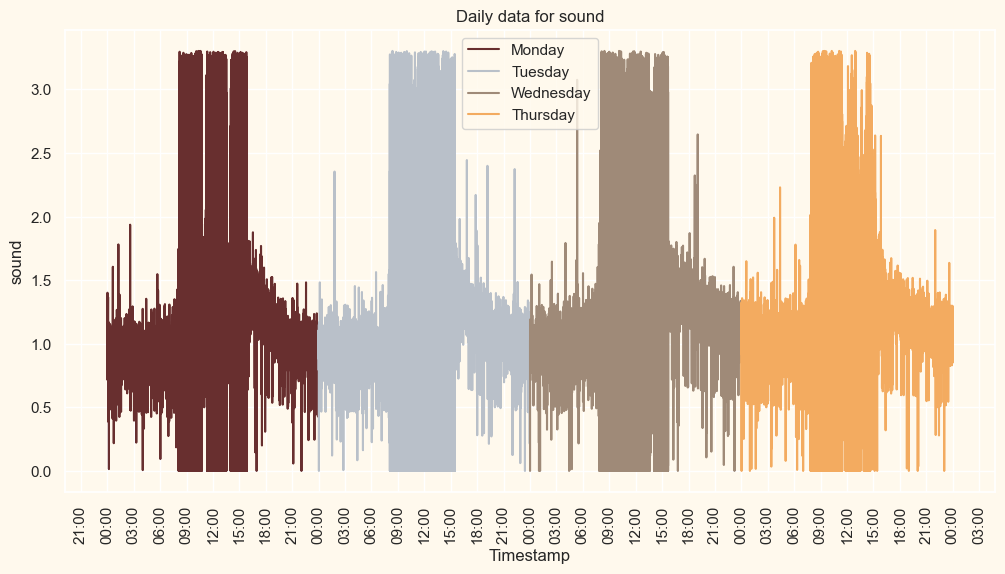

In [13]:
draw_unique_days(df_daily, unique_days, 'sound', labels)

Na osnovu zvuka mozemo zakljuciti da je period rada u toku jednog radnog dana najverovatnije od 08:00h do 16:00h. Zato sto je zvuk u tom periodu najintenzivniji u prostoriji.

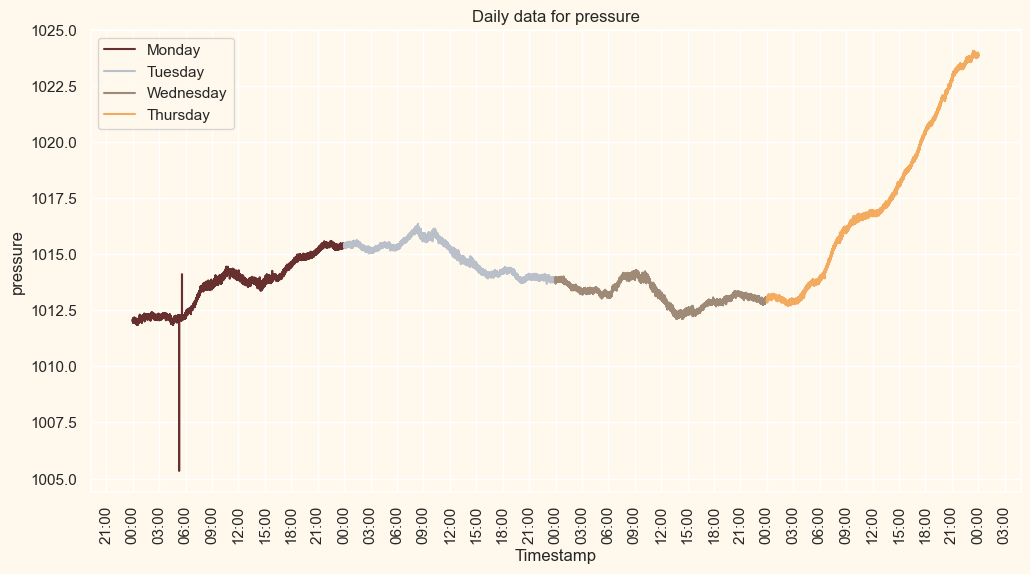

In [14]:
draw_unique_days(df_daily, unique_days, 'pressure', labels)

U slucaju sa pritiskom se ne moze najjasnije zakljuciti na osnovu grafika bilo kakvo postojanje nekakvog obrasca. Vidimo da postoji neka potencijalna greska uredjaja u ponedeljak u 05:00h.

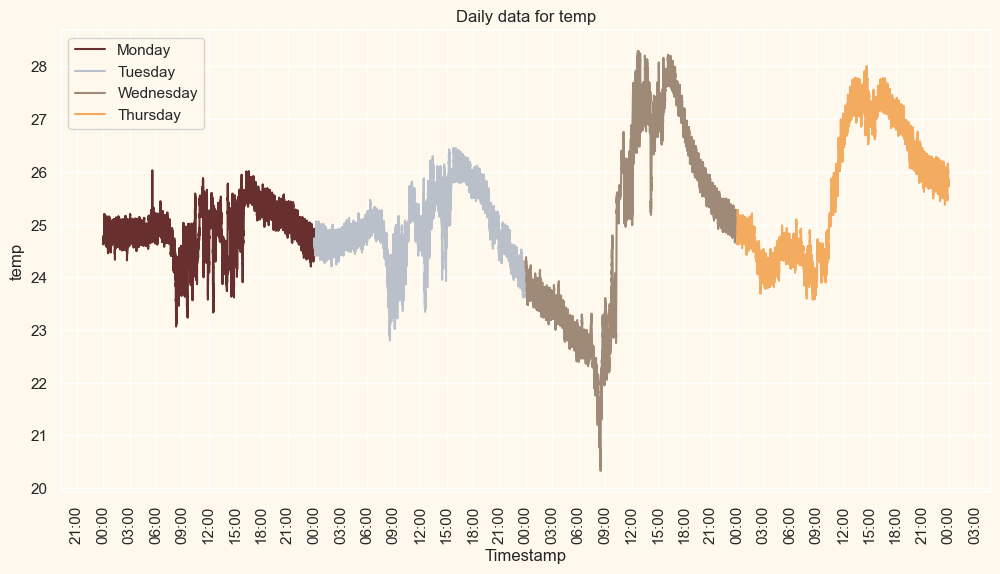

In [15]:
draw_unique_days(df_daily, unique_days, 'temp', labels)

Svakog dana oko pola 9 se detektuje najniza temperatura. Razlog za ovo moze biti taj sto u to vreme radnici dolaze, eventualno otvaraju vrata i prozore kako bi rashladili prostorije. Tokom noci su temperature najvece.

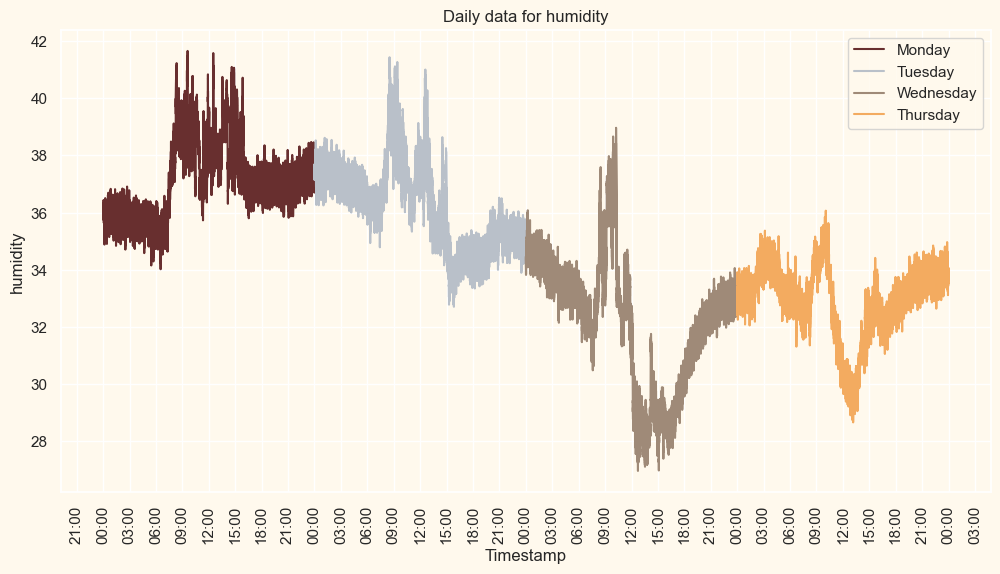

In [16]:
draw_unique_days(df_daily, unique_days, 'humidity', labels)

Vlaznost vazduha kao da je obrnuto proporcionalna u odnosu na temperaturu. U periodima padova temperature, vlaznost vazduha raste i obratno.

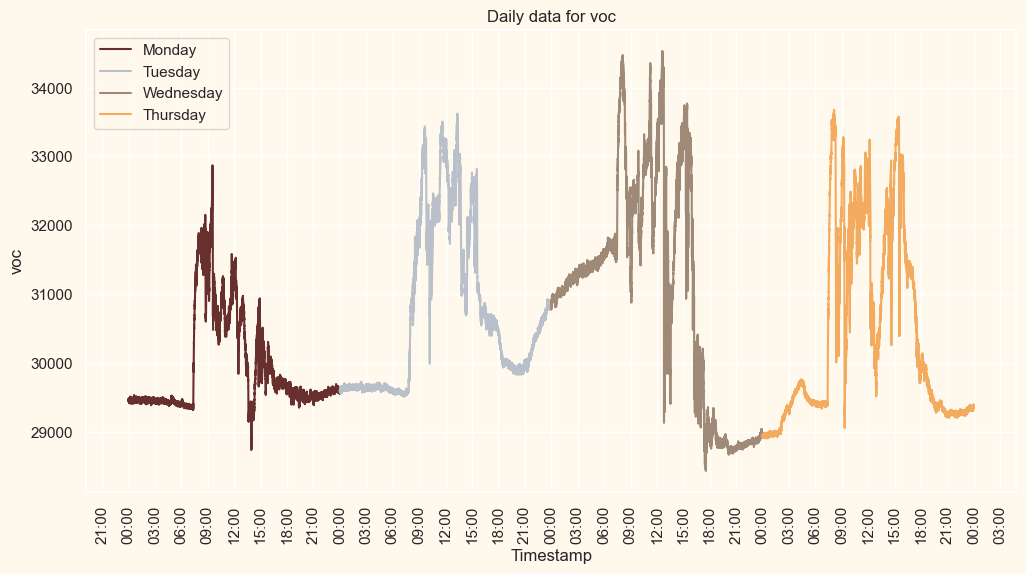

In [17]:
draw_unique_days(df_daily, unique_days, 'voc', labels)


Isparljiva organska jedinjenja se u prostoriji nalaze u najvecoj koncentraciji za vreme radnog vremena, sto je i ocekivano.

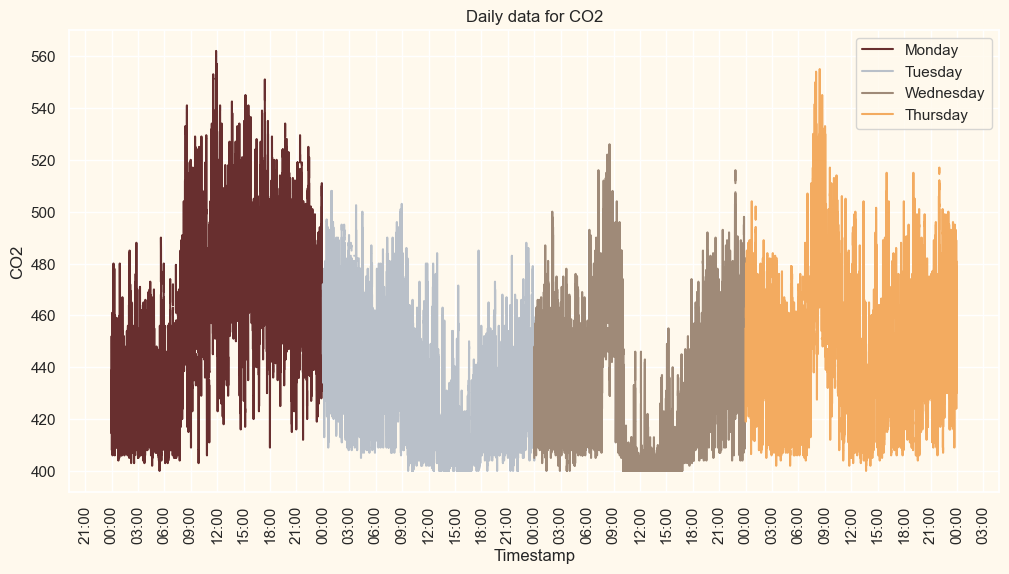

In [18]:
draw_unique_days(df_daily, unique_days, 'CO2', labels)


Najveca koncentracija u periodu radnog vremena.

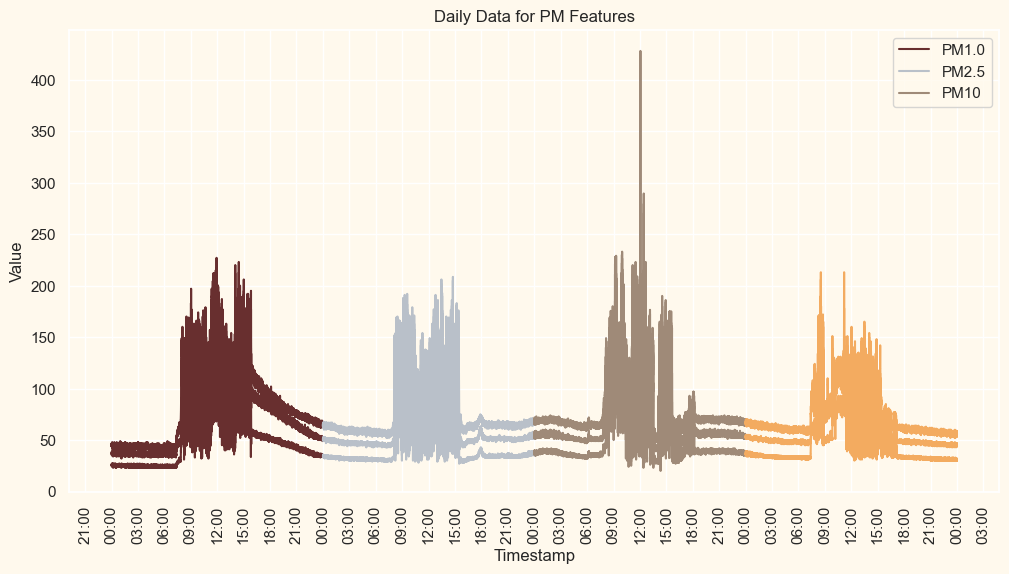

In [19]:
plt.figure(figsize=(12, 6))

features = ['pm1.0', 'pm2.5', 'pm10']
labels = ['PM1.0', 'PM2.5', 'PM10']

for feature in features:
    for day in unique_days:
        day_data = df_daily[df_daily.index.date == day.date()]
        plt.plot(day_data.index, day_data[feature], label=feature)
    
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Daily Data for PM Features')
plt.legend(labels=labels)
plt.grid(True)
plt.xticks(rotation=90)

# Set x-axis labels every 6 hours
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.show()


Najveca koncentracija u periodu radnog vremena.

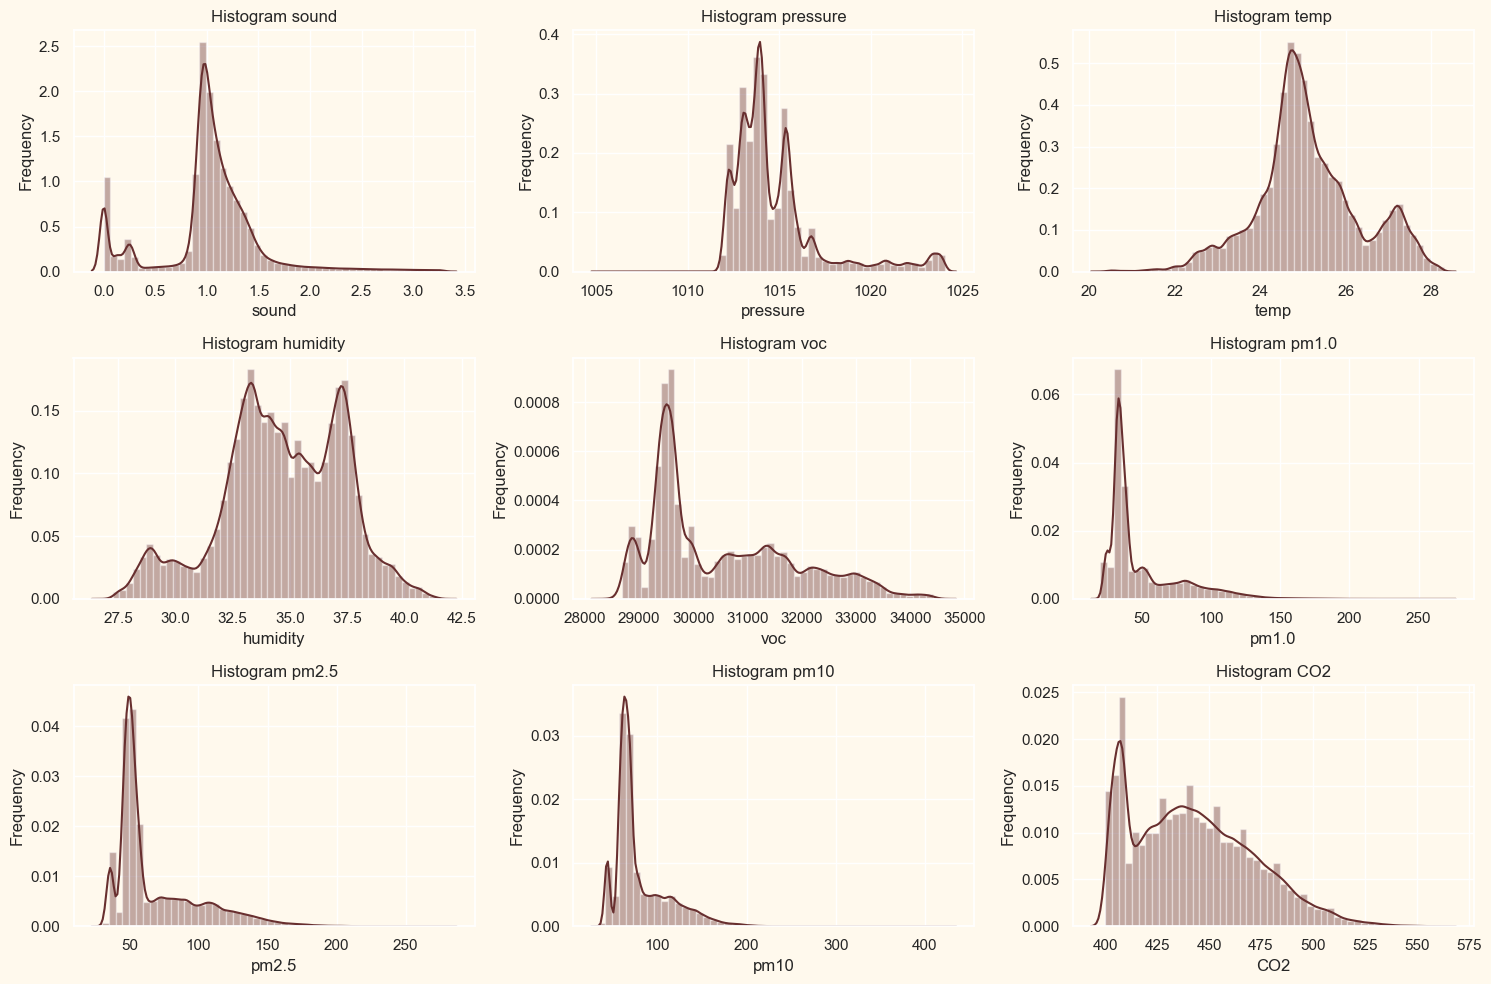

In [20]:
broj_grafikona_po_redu = 3
broj_grafikona_po_koloni = 3

fig, axs = plt.subplots(broj_grafikona_po_koloni, broj_grafikona_po_redu, figsize=(15, 10))

indeks_grafikona = 0

for red in range(broj_grafikona_po_koloni):
    for kolona in range(broj_grafikona_po_redu):
        
        if indeks_grafikona < len(df.columns):

            atribut = df.columns[indeks_grafikona]
            
            axs[red, kolona].set_ylabel('Frequency')
            axs[red, kolona].set_xlabel(atribut)
            axs[red, kolona].set_title('Histogram {}'.format(atribut))
            sns.distplot(df[atribut], ax=axs[red, kolona])
            
            indeks_grafikona += 1
            
plt.tight_layout()
plt.show()

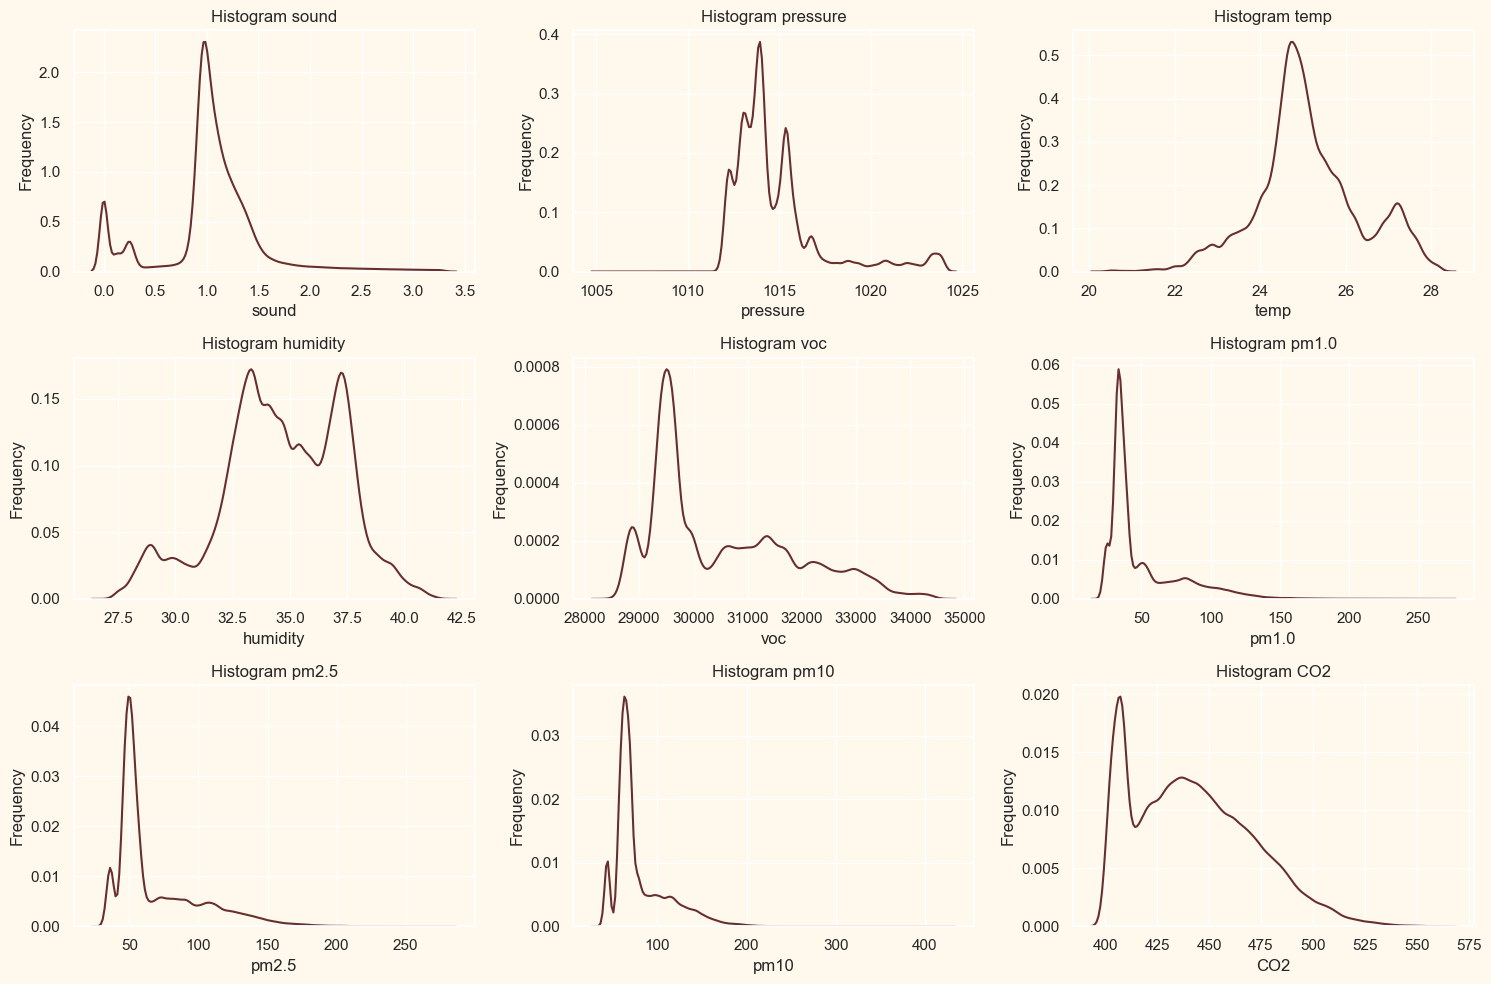

In [21]:
broj_grafikona_po_redu = 3
broj_grafikona_po_koloni = 3

fig, axs = plt.subplots(broj_grafikona_po_koloni, broj_grafikona_po_redu, figsize=(15, 10))

indeks_grafikona = 0

for red in range(broj_grafikona_po_koloni):
    for kolona in range(broj_grafikona_po_redu):
        
        if indeks_grafikona < len(df.columns):

            atribut = df.columns[indeks_grafikona]
            
            axs[red, kolona].set_ylabel('Frequency')
            axs[red, kolona].set_xlabel(atribut)
            axs[red, kolona].set_title('Histogram {}'.format(atribut))
            sns.kdeplot(df[atribut], ax=axs[red, kolona])
            
            indeks_grafikona += 1
            
# podesite raspored grafikona i prikažite ih
plt.tight_layout()
plt.show()

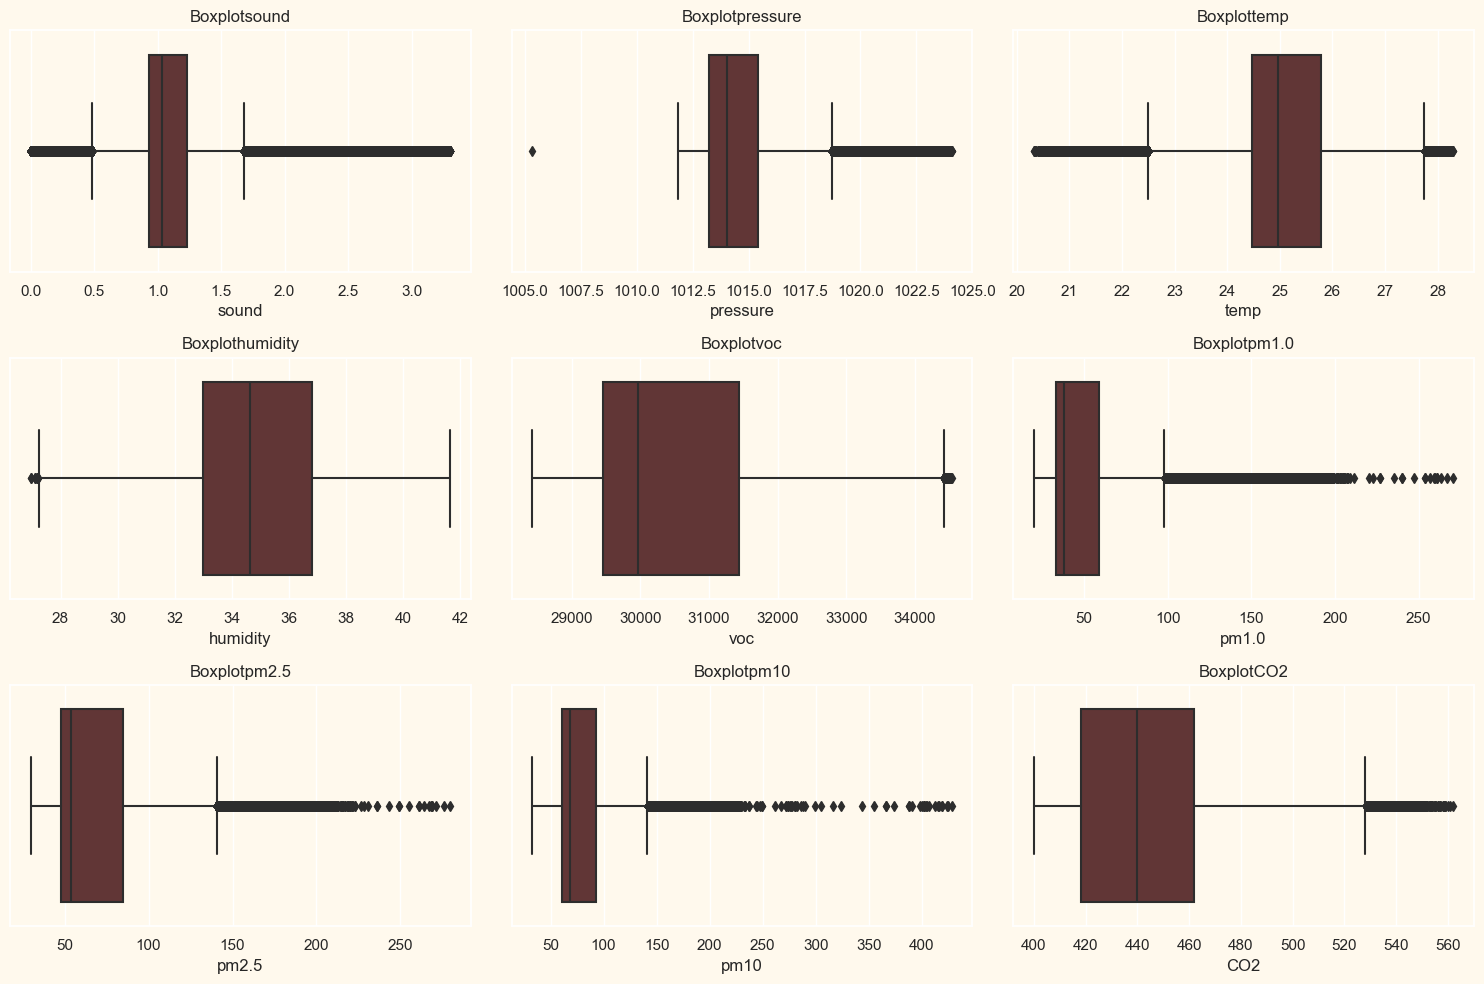

In [22]:
broj_grafikona_po_redu = 3
broj_grafikona_po_koloni = 3

fig, axs = plt.subplots(broj_grafikona_po_koloni, broj_grafikona_po_redu, figsize=(15, 10))

indeks_grafikona = 0

for red in range(broj_grafikona_po_koloni):
    for kolona in range(broj_grafikona_po_redu):
        
        if indeks_grafikona < len(df.columns):

            atribut = df.columns[indeks_grafikona]
            
            axs[red, kolona].set_xlabel(atribut)
            axs[red, kolona].set_title('Boxplot{}'.format(atribut))
            sns.boxplot(data=df, x = atribut ,ax=axs[red, kolona])
            
            indeks_grafikona += 1
            
# podesite raspored grafikona i prikažite ih
plt.tight_layout()
plt.show()

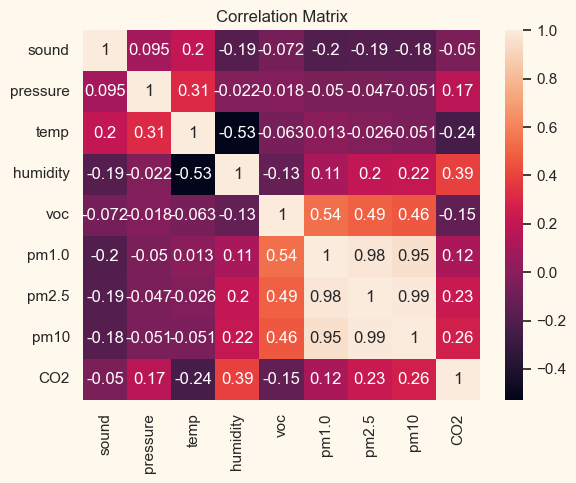

In [23]:
sns.heatmap(df.corr(), annot=True)
plt.title('Correlation Matrix')
plt.show()

Zbog visoke korelacije izmedju pm atributa, javlja se mogucnost njihovog stapanja u jedan atribut.

In [24]:
def moving_average(df, window_size, column):
    custom_palette = ["#682F2F", "#F3AB60", "#5E8C31", "#5B82AA", "#F0E68C"]
    sns.set_palette(custom_palette)
    df[column + '_moving_average'] = df[column].rolling(window=window_size).mean()
    df[column + '_median'] = df[column].rolling(window=window_size).median()
    df[column + '_variance'] = df[column].rolling(window=window_size).var()
    df[column + '_std'] = df[column].rolling(window=window_size).std()

    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df[column], label='Original Data')
    plt.plot(df.index, df[column + '_moving_average'], label=f'Moving Average ({window_size/3600}-hours)')
    plt.plot(df.index, df[column + '_median'], label=f'Median ({window_size/3600}-hours)')
    plt.plot(df.index, df[column + '_variance'], label=f'Variance ({window_size/3600}-hours)')
    plt.plot(df.index, df[column + '_std'], label=f'Standard Deviation ({window_size/3600}-hours)')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title(f'{column} with Moving Average, Median, Variance, and Standard Deviation')
    plt.legend()
    plt.show()

    df.drop(column + '_moving_average', axis=1, inplace=True)
    df.drop(column + '_median', axis=1, inplace=True)
    df.drop(column + '_variance', axis=1, inplace=True)
    df.drop(column + '_std', axis=1, inplace=True)

def moving_average_without_std(df, window_size, column):
    custom_palette = ["#682F2F", "#F3AB60", "#5E8C31", "#5B82AA", "#F0E68C"]
    sns.set_palette(custom_palette)
    df[column + '_moving_average'] = df[column].rolling(window=window_size).mean()
    df[column + '_median'] = df[column].rolling(window=window_size).median()

    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df[column], label='Original Data')
    plt.plot(df.index, df[column + '_moving_average'], label=f'Moving Average ({window_size/3600}-hours)')
    plt.plot(df.index, df[column + '_median'], label=f'Median ({window_size/3600}-hours)')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title(f'{column} with Moving Average, Median')
    plt.legend()
    plt.show()

    df.drop(column + '_moving_average', axis=1, inplace=True)
    df.drop(column + '_median', axis=1, inplace=True)

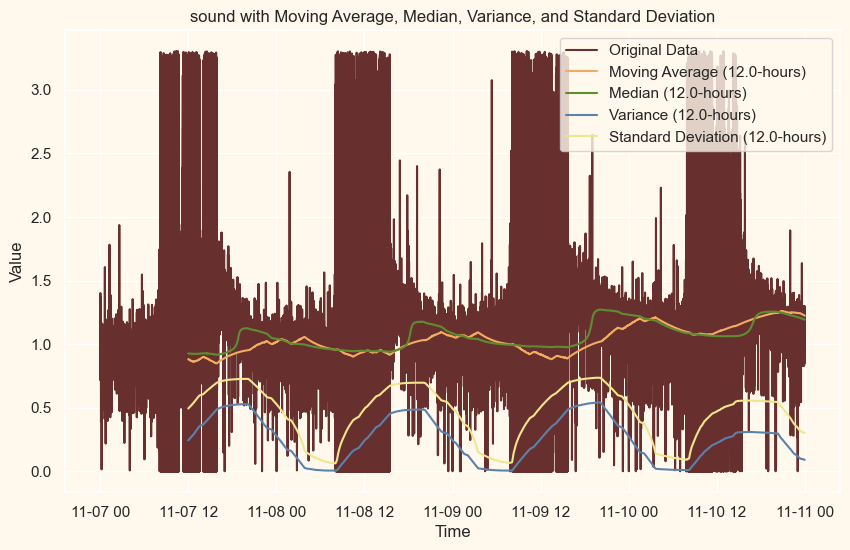

In [25]:
hour12 = 3600*12
moving_average(df, hour12, 'sound')

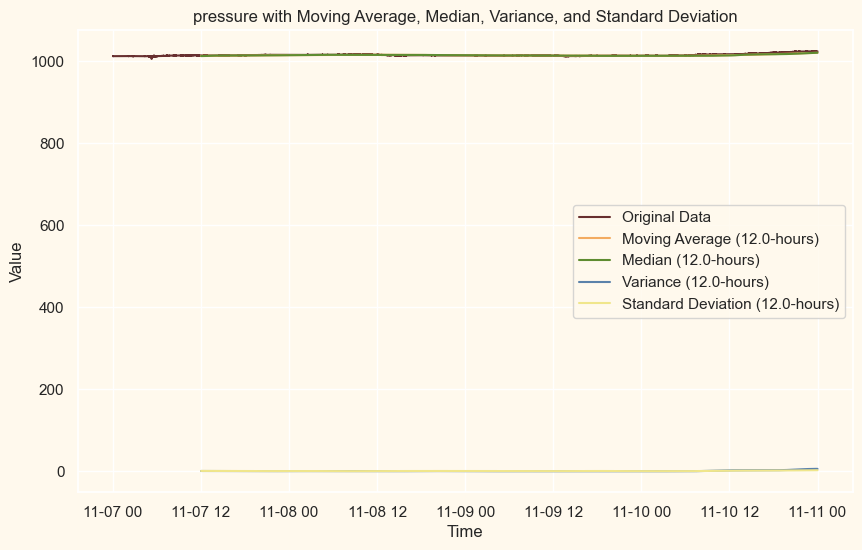

In [26]:
moving_average(df, hour12, 'pressure')

Primećujemo da je standardna devijacija veoma niska. Ovo znači da postoje veoma mala odstupanja. Na ovo ukazuje i delimično normalna raspodela.

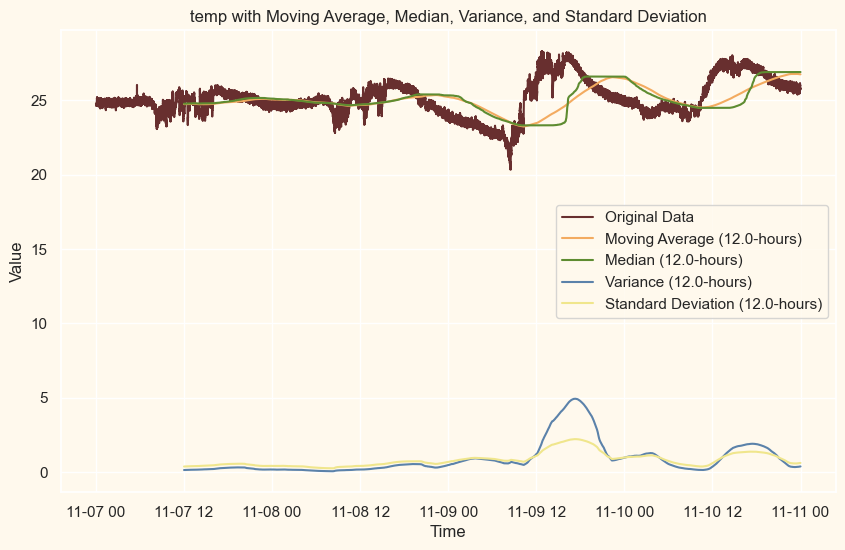

In [27]:
moving_average(df, hour12, 'temp')

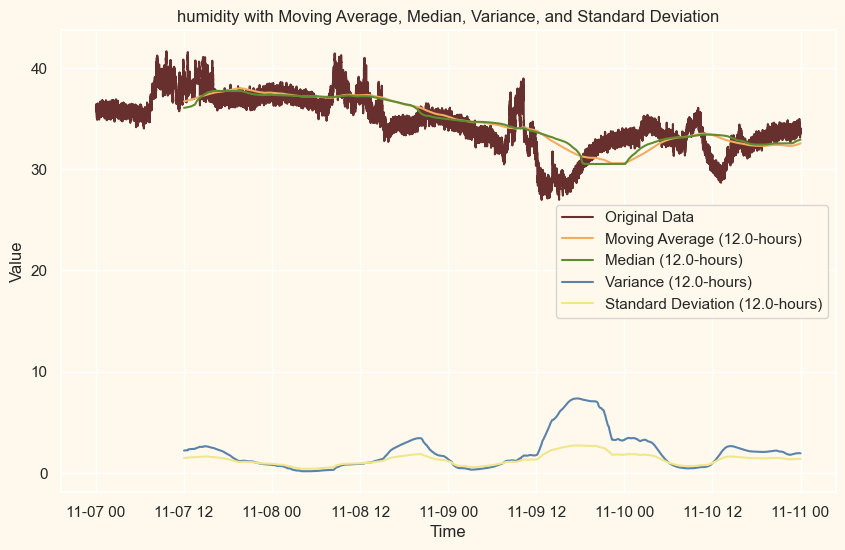

In [28]:
moving_average(df, hour12, 'humidity')

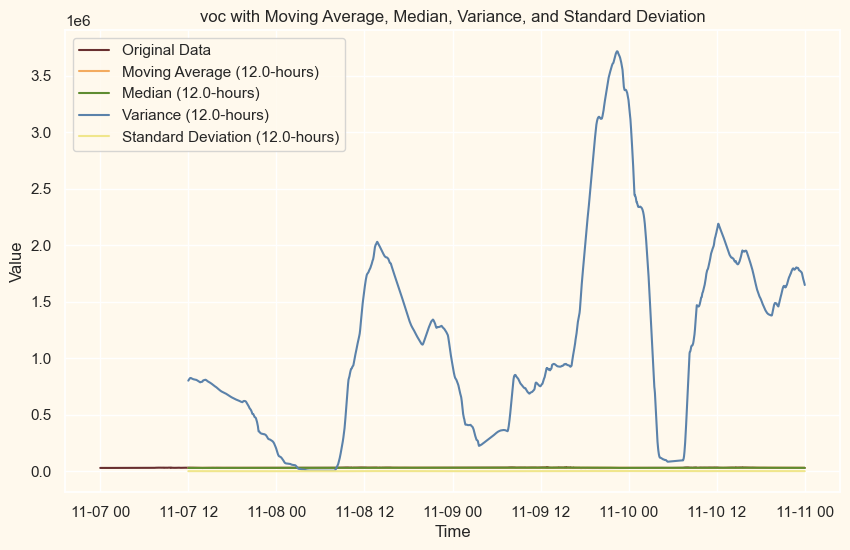

In [29]:
moving_average(df, hour12, 'voc')

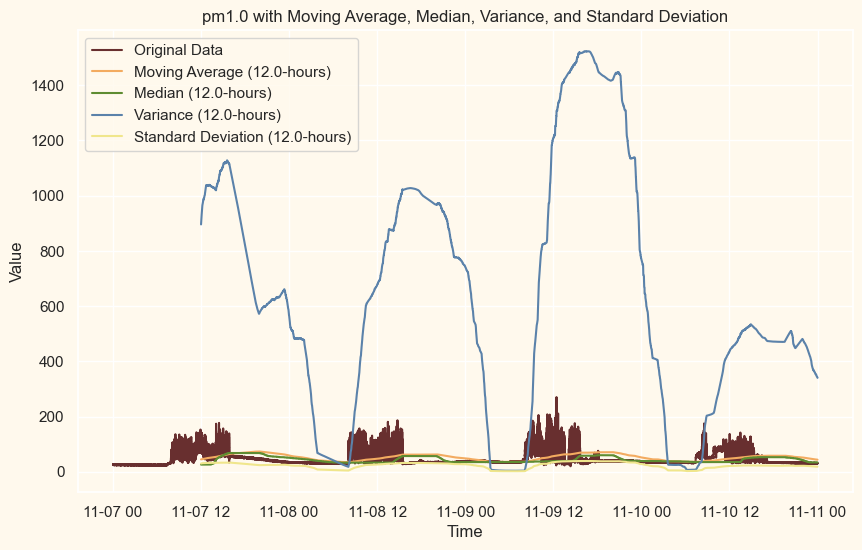

In [30]:
moving_average(df, hour12, 'pm1.0')

U pitanju su datumi jedne radne nedelje  (Ponedeljak - Četvrtak).

Sound, voc, pm-ovi su noci drasticno manji, sto je i ocekivano.

9. Novembra se dasticno smanjio CO2, temperatura i vlaznost, a drasticno je skocio pm, a i voc je bio najvisi od svih.

# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Preprocesiranje podataka</p>

In [31]:
df.columns

Index(['sound', 'pressure', 'temp', 'humidity', 'voc', 'pm1.0', 'pm2.5',
       'pm10', 'CO2'],
      dtype='object')

In [32]:
df.isnull().sum()

sound         0
pressure      0
temp          0
humidity      0
voc           0
pm1.0         0
pm2.5         0
pm10          0
CO2         887
dtype: int64

Potrebno je izvršiti adekvatnu zamenu nedostajućih podataka. Zbog ovoga, neophodno je ispitati da li se nedostajuće vrednosti pojavljuju u regularnim vremenskim intervalima ili ne.

In [33]:
missing_df = df[df['CO2'].isna()]

# Compute time differences between missing values
time_diff = missing_df.index.to_series().diff()

# Check if time differences are equal to time interval
is_regular = all(time_diff == time_diff.iloc[0])

if is_regular:
    print("Missing values occur at regular intervals.")
else:
    print("Missing values do not occur at regular intervals.")

Missing values do not occur at regular intervals.


S obzirom da se ne pojavljuju u regularnim vremenskim intervalima, dovoljno je zameniti ih metodom linearne interpolacije.

In [34]:
df['CO2'] = df['CO2'].interpolate(method='linear')
df.isnull().sum()

sound       0
pressure    0
temp        0
humidity    0
voc         0
pm1.0       0
pm2.5       0
pm10        0
CO2         0
dtype: int64

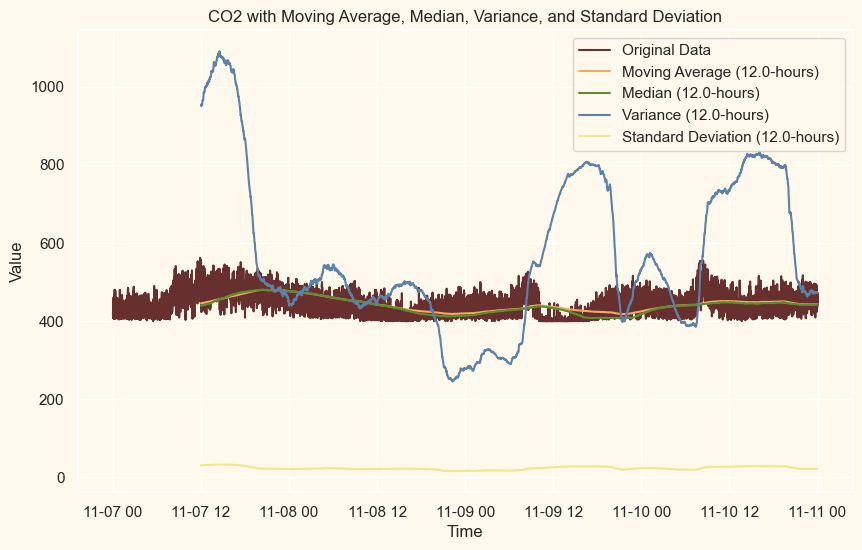

In [35]:
moving_average(df, hour12, 'CO2')

In [36]:
df.head()

sound     pressure       temp   humidity      voc  \
timestamp                                                                   
2022-11-07 00:00:01  0.881076  1012.037290  24.777757  35.996349  29466.0   
2022-11-07 00:00:02  0.863325  1012.025698  24.762371  36.002125  29467.0   
2022-11-07 00:00:03  0.908509  1012.083523  24.767500  36.013384  29459.0   
2022-11-07 00:00:04  0.924645  1012.091207  24.767500  36.013384  29454.0   
2022-11-07 00:00:05  0.896406  1012.091207  24.764935  36.013405  29458.5   

                     pm1.0  pm2.5  pm10    CO2  
timestamp                                       
2022-11-07 00:00:01   26.0   36.0  45.0  421.0  
2022-11-07 00:00:02   26.0   36.0  45.0  419.0  
2022-11-07 00:00:03   26.0   36.0  45.0  418.0  
2022-11-07 00:00:04   26.0   36.0  44.0  418.0  
2022-11-07 00:00:05   26.0   36.0  44.0  416.0

In [37]:
df.duplicated().sum()

0

In [38]:
df.shape

(345151, 9)

In [39]:
df_resampled = df.resample('1S').mean()

df_resampled = df_resampled.interpolate()

new_index = pd.date_range(start=df_resampled.index[0], end=df_resampled.index[-1], freq='1S')

df_resampled.index = new_index

In [40]:
df_resampled.shape, df.shape

((345599, 9), (345151, 9))

In [41]:
df_resampled.isna().sum()

sound       0
pressure    0
temp        0
humidity    0
voc         0
pm1.0       0
pm2.5       0
pm10        0
CO2         0
dtype: int64

In [42]:
df_resampled.shape

(345599, 9)

In [43]:
def IQR(data, column, threshold=1.5):
    
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - threshold * iqr
    upper = q3 + threshold * iqr
    outliers = data[(data[column] < lower) | (data[column] > upper)]
    return outliers

In [44]:
num = df_resampled.shape[0]
for column in df_resampled.columns:
    outliers = IQR(df_resampled, column, threshold=1.5)
    df_resampled = df_resampled[~df_resampled.index.isin(outliers.index)]
print(f"Broj izbačenih outliera je: {num - df_resampled.shape[0]}")

Broj izbačenih outliera je: 200567


In [45]:
df_resampled.shape

(145032, 9)

# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Redukcija atributa</p>

In [46]:
df_resampled_reduced = df_resampled.copy()
pca1 = PCA(n_components=1)
df_resampled_reduced['PCA_pm'] = pca1.fit_transform(df_resampled[['pm1.0', 'pm2.5', 'pm10']])
df_resampled_reduced.drop(['pm1.0','pm2.5','pm10'],axis=1, inplace=True)
df_resampled_reduced

sound     pressure       temp   humidity      voc  \
2022-11-07 00:00:32  0.803619  1012.099019  24.716214  36.053346  29467.0   
2022-11-07 00:00:33  0.955306  1012.068283  24.716214  36.064645  29459.0   
2022-11-07 00:00:34  1.045672  1012.068283  24.716214  36.064645  29454.0   
2022-11-07 00:00:35  0.824597  1012.049011  24.721343  35.979857  29456.5   
2022-11-07 00:00:36  1.216724  1012.014371  24.731600  35.889372  29459.0   
...                       ...          ...        ...        ...      ...   
2022-11-10 15:39:22  1.342592  1018.624343  26.757399  33.680077  32406.0   
2022-11-10 15:39:23  1.361956  1018.589577  26.757399  33.668718  32431.0   
2022-11-10 15:39:24  1.266748  1018.616624  26.762527  33.674325  32434.0   
2022-11-10 15:39:25  1.395844  1018.678438  26.762527  33.680005  32455.0   
2022-11-10 15:39:26  1.357115  1018.624343  26.752270  33.680149  32499.0   

                       CO2     PCA_pm  
2022-11-07 00:00:32  422.0  25.155128  
2022-11-07 00:00:33  422.0  25.155128  
2022-11-07 00:00:34  423.0  25.155128  
2022-11-07 00:00:35  425.5  24.558151  
2022-11-07 00:00:36  426.0  24.558151  
...                    ...        ...  
2022-11-10 15:39:22  443.0 -16.593673  
2022-11-10 15:39:23  445.0 -16.593673  
2022-11-10 15:39:24  445.0 -20.249212  
2022-11-10 15:39:25  446.0 -20.249212  
2022-11-10 15:39:26  448.0 -20.249212  

[145032 rows x 7 columns]

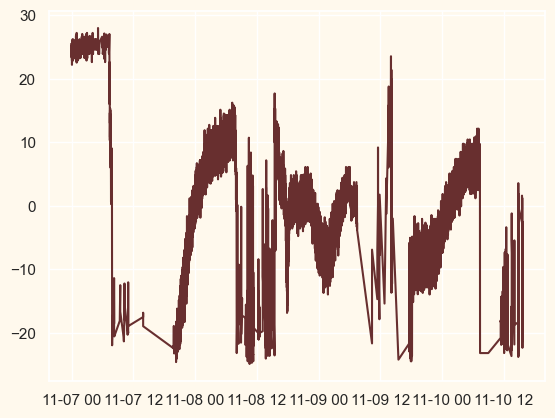

In [47]:
plt.plot(df_resampled_reduced['PCA_pm']);

Nadalje nije koriscen reduced

In [48]:
stdScaler = StandardScaler()
df_standardized = df_resampled_reduced.copy()
df_standardized = pd.DataFrame(stdScaler.fit_transform(df_standardized), columns = df_standardized.columns)
df_standardized.index = df_resampled.index

In [49]:
df_standardized.head()

sound  pressure      temp  humidity       voc  \
2022-11-07 00:00:32 -1.849224 -2.000813 -0.075771  0.704198 -0.485969   
2022-11-07 00:00:33 -0.737941 -2.031823 -0.075771  0.710286 -0.495797   
2022-11-07 00:00:34 -0.075900 -2.031823 -0.075771  0.710286 -0.501940   
2022-11-07 00:00:35 -1.695536 -2.051268 -0.069247  0.664597 -0.498868   
2022-11-07 00:00:36  1.177249 -2.086216 -0.056199  0.615839 -0.495797   

                          CO2    PCA_pm  
2022-11-07 00:00:32 -0.748223  3.238568  
2022-11-07 00:00:33 -0.748223  3.238568  
2022-11-07 00:00:34 -0.702823  3.238568  
2022-11-07 00:00:35 -0.589325  3.161711  
2022-11-07 00:00:36 -0.566625  3.161711

In [50]:
df_standardized.isna().sum()

sound       0
pressure    0
temp        0
humidity    0
voc         0
CO2         0
PCA_pm      0
dtype: int64

In [51]:
def adf_test(timeseries, name):
    print(f'\nRezultati Dickey-Fuller testa za {name}:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput.to_string())

    if dftest[1] < 0.05:
        print(f"Podaci {name} su stacionarni.")
    else:
        print(f"Podaci {name} nisu stacionarni.")

In [52]:
#for column in df_standardized.columns:
   # adf_test(df_standardized[column], column)

Primećujemo da podaci za pressure nisu stacionarni. Međutim, ruptures biblioteka i algoritmi koji su implementirani u okviru nje su namenjeni za nestacionarne timeseries podatke. Tako da nema potrebe pretvarati ih u stacionarne.

# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Change point detection (Univariate)</p>

In [53]:
def PeltChangePointDetection(timeseries, kernel="linear", min_size=1, jump=1, pen=30):
    signal = timeseries.values
    algo_c = rpt.KernelCPD(kernel=kernel, min_size=min_size, jump=jump,).fit(signal)  # written in C, same class as before
    return algo_c.predict(pen=pen)

def BinSegChangePointDetection(timeseries, model="l2", min_size=1, jump=1, pen=30):
    signal = timeseries.values
    algo = rpt.Binseg(model=model, min_size=min_size, jump=jump).fit(signal)
    return algo.predict(pen=pen)

def DrawGraphs(df, feature, bkps1, bkps2):
    fig, axs = plt.subplots(ncols=2, figsize=(15,5))
    axs[0].plot(df[feature], color="#9F8A78")
    axs[0].set_title("Pelt Change Point Detection ({})".format(feature.upper()))
    for r in bkps1:
        axs[0].axvline(x=df.index[r-1], color="#F3AB60", linestyle='--')
    
    axs[1].plot(df[feature], color="#9F8A78")
    axs[1].set_title("BinSeg Change Point Detection ({})".format(feature.upper()))
    for r in bkps2:
        axs[1].axvline(x=df.index[r-1], color="#F3AB60", linestyle='--')

def calculate_magnitude(feature, bkps):
    magnitudes = []
    for i in range(len(bkps)-1):
        segment = feature[bkps[i]:bkps[i+1]]
        magnitude = np.abs(segment[-1] - segment[0])
        magnitudes.append(magnitude)
    return magnitudes

def plot_magnitudes(bkps1, bkps2, magnitudes1, magnitudes2, width=1300):
    magnitudes1.append(0)
    magnitudes2.append(0)
    fig, axs = plt.subplots(ncols=2, figsize=(15,5))

    axs[0].bar(bkps1, magnitudes1, width, color="#9F8A78")
    axs[0].set_title("Pelt Change Point Detection Magnitudes")
    # Add a dummy magnitude at the beginning to align with change points
    
    axs[1].bar(bkps2, magnitudes2, width, color="#F3AB60")
    axs[1].set_title("BinSeg Change Point Detection Magnitudes")
    
    axs[0].set_xlabel('Change Point Index')
    axs[0].set_ylabel('Magnitude')

    axs[1].set_xlabel('Change Point Index')
    axs[1].set_ylabel('Magnitude')
    plt.title('Magnitudes of Detected Changes')
    plt.show()

    magnitudes1.pop(-1)
    magnitudes2.pop(-1)
    
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

def calculate_magnitudes_multivariate(df, bkps):
    values = df.values
    distances = []
    for i in range(len(bkps)-2):
        segment_before = values[bkps[i],:]
        segment_after = values[bkps[i+1],:]
        distance = euclidean_distance(segment_after, segment_before)
        distances.append(distance)
    return distances



In [131]:
signal_sound = df_standardized['sound'].values
signal_pressure = df_standardized['pressure'].values
signal_temp = df_standardized['temp'].values
signal_humidity = df_standardized['humidity'].values
signal_voc = df_standardized['voc'].values
signal_CO2 = df_standardized['CO2'].values
signal_PCA_pm = df_standardized['PCA_pm'].values

penalty_values = np.arange(1, 150, 50)  # Adjust range as needed
num_change_points_sound = []
num_change_points_pressure = []
num_change_points_temp = []
num_change_points_humidity = []
num_change_points_voc = []
num_change_points_CO2 = []
num_change_points_PCA_pm = []

# Calculate the number of change points for each penalty value
for penalty in penalty_values:
    algo_c_sound = rpt.KernelCPD(kernel="linear", min_size=5, jump=10).fit(signal_sound)
    algo_c_pressure = rpt.KernelCPD(kernel="linear", min_size=5, jump=10).fit(signal_pressure)
    algo_c_temp = rpt.KernelCPD(kernel="linear", min_size=5, jump=10).fit(signal_temp)
    algo_c_humidity = rpt.KernelCPD(kernel="linear", min_size=5, jump=10).fit(signal_humidity)
    algo_c_voc = rpt.KernelCPD(kernel="linear", min_size=5, jump=10).fit(signal_voc)
    algo_c_CO2 = rpt.KernelCPD(kernel="linear", min_size=5, jump=10).fit(signal_CO2)
    algo_c_PCA_pm = rpt.KernelCPD(kernel="linear", min_size=5, jump=10).fit(signal_PCA_pm)
    
    
    result_sound = algo_c_sound.predict(pen=penalty)
    result_pressure = algo_c_pressure.predict(pen=penalty)
    result_temp = algo_c_temp.predict(pen=penalty)
    result_humidity = algo_c_humidity.predict(pen=penalty)
    result_voc = algo_c_voc.predict(pen=penalty)
    result_CO2 = algo_c_CO2.predict(pen=penalty)
    result_PCA_pm = algo_c_PCA_pm.predict(pen=penalty)
    
    num_change_points_sound.append(len(result_sound))
    num_change_points_pressure.append(len(result_pressure))
    num_change_points_temp.append(len(result_temp))
    num_change_points_humidity.append(len(result_humidity))
    num_change_points_voc.append(len(result_voc))
    num_change_points_CO2.append(len(result_CO2))
    num_change_points_PCA_pm.append(len(result_PCA_pm))

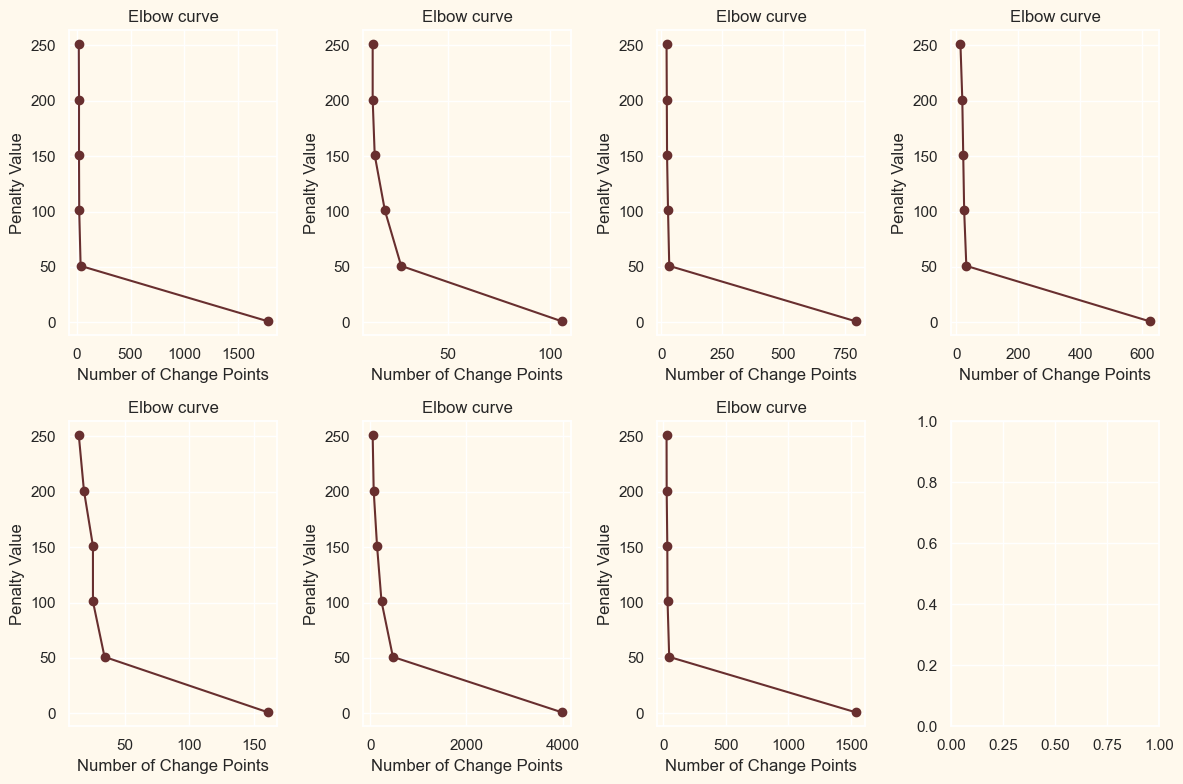

In [165]:
import matplotlib.pyplot as plt

# Data for plotting (replace with your actual data)
num_change_points_list = [num_change_points_sound, num_change_points_pressure, num_change_points_temp,
                          num_change_points_humidity, num_change_points_voc, num_change_points_CO2,
                          num_change_points_PCA_pm]
penalty_values2 = [penalty_values] * len(num_change_points_list)

# Create a grid of subplots
num_plots = len(num_change_points_list)
num_rows = 2
num_cols = (num_plots + 1) // num_rows

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

for i, (num_change_points, penalties) in enumerate(zip(num_change_points_list, penalty_values2)):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col] if num_plots > 1 else axes

    ax.plot(num_change_points, penalties, marker='o')
    ax.set_xlabel("Number of Change Points")
    ax.set_ylabel("Penalty Value")
    ax.set_title("Elbow curve")
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


Primećujemo da je za sve slučajeve najoptimalnija vrednost otprilike 52 za penalty_value

In [139]:
sound_bkps = PeltChangePointDetection(df_standardized['sound'], min_size=10, jump=5, pen=52)
sound_bkps2 = BinSegChangePointDetection(df_standardized['sound'], min_size=10, jump=5, pen=100)

pressure_bkps = PeltChangePointDetection(df_standardized['pressure'], min_size=10, jump=5, pen=52)
pressure_bkps2 = BinSegChangePointDetection(df_standardized['pressure'], min_size=10, jump=5, pen=100)

temp_bkps = PeltChangePointDetection(df_standardized['temp'], min_size=10, jump=5, pen=52)
temp_bkps2 = BinSegChangePointDetection(df_standardized['temp'], min_size=10, jump=5, pen=100)

humidity_bkps = PeltChangePointDetection(df_standardized['humidity'], min_size=10, jump=5, pen=52)
humidity_bkps2 = BinSegChangePointDetection(df_standardized['temp'], min_size=10, jump=5, pen=100)

voc_bkps = PeltChangePointDetection(df_standardized['voc'], min_size=10, jump=5, pen=52)
voc_bkps2 = BinSegChangePointDetection(df_standardized['voc'], min_size=10, jump=5, pen=100)

CO2_bkps = PeltChangePointDetection(df_standardized['CO2'], min_size=10, jump=5, pen=52)
CO2_bkps2 = BinSegChangePointDetection(df_standardized['CO2'], min_size=10, jump=5, pen=100)

PCA_pm_bkps = PeltChangePointDetection(df_standardized['PCA_pm'], min_size=10, jump=5, pen=52)
PCA_pm_bkps2 = BinSegChangePointDetection(df_standardized['PCA_pm'], min_size=10, jump=5, pen=100)

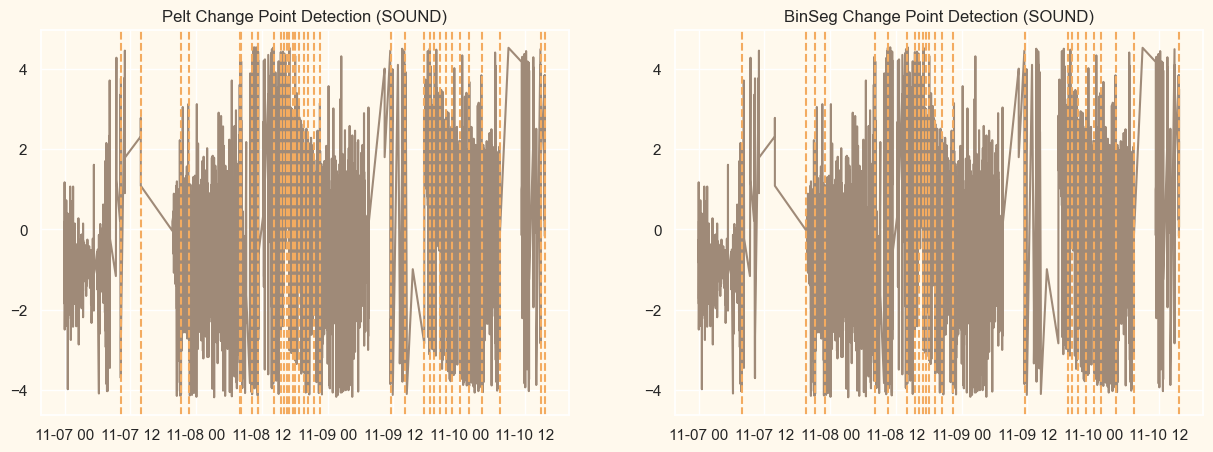

In [166]:
DrawGraphs(df_standardized, 'sound', sound_bkps, sound_bkps2)

In [167]:
magnitudes_pelt = calculate_magnitude(df_standardized['sound'], sound_bkps)
magnitudes_binseg = calculate_magnitude(df_standardized['sound'], sound_bkps2)

print(magnitudes_pelt)
print(magnitudes_binseg)


[0.1418659060996732, 1.223593440109684, 0.40195340061574136, 0.4374198771406614, 1.5368806494131309, 4.060911562103158, 1.3181707108427982, 0.8157289600731233, 2.0334113207619886, 2.009767003078709, 1.6905687143544421, 0.6383965774485305, 0.07093295304983682, 0.03546647652491908, 0.2600874945160685, 0.11231050899557216, 0.0709329530498366, 2.151632909178382, 1.1940380430055864, 0.7566181658649274, 0.46697527424475893, 0.496530671348856, 2.600874945160683, 0.5556414655570543, 0.16551022378295266, 0.92212838964788, 0.4374198771406589, 0.602930100923613, 0.15959914436213424, 0.957594866172799, 1.0521721369059132, 0.07093295304983493, 5.337704717000219, 1.4423033786800148]
[0.6738630539734496, 0.496530671348859, 0.24826533567442793, 1.241326678372145, 4.652019504185133, 2.062966717866086, 0.21279885914950958, 0.27782073277852604, 0.35466476524918455, 0.08275511189147622, 0.1182215884163953, 0.1182215884163953, 0.03546647652491752, 0.42559771829902004, 0.6738630539734495, 5.645080846882847,

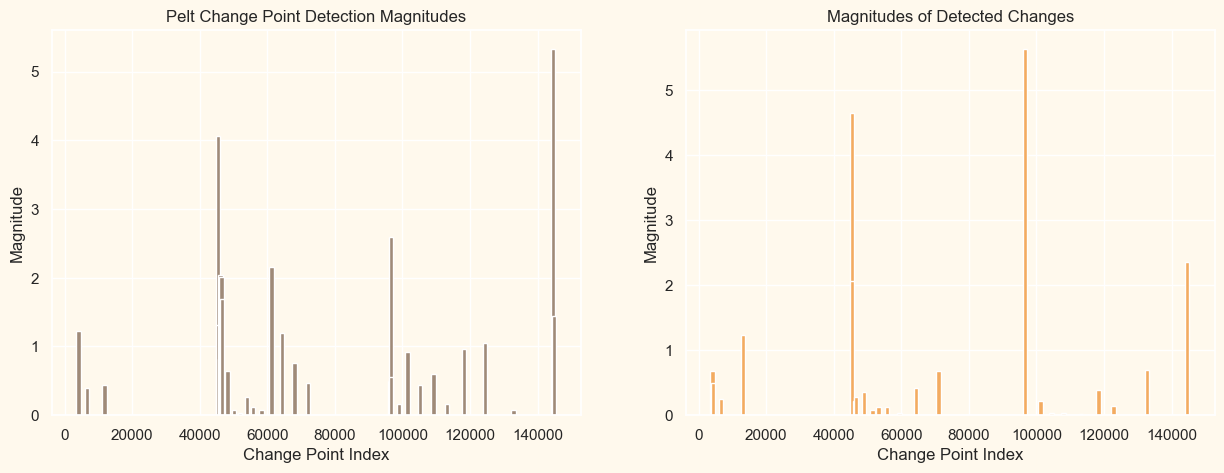

In [168]:
plot_magnitudes(sound_bkps, sound_bkps2, magnitudes_pelt, magnitudes_binseg)

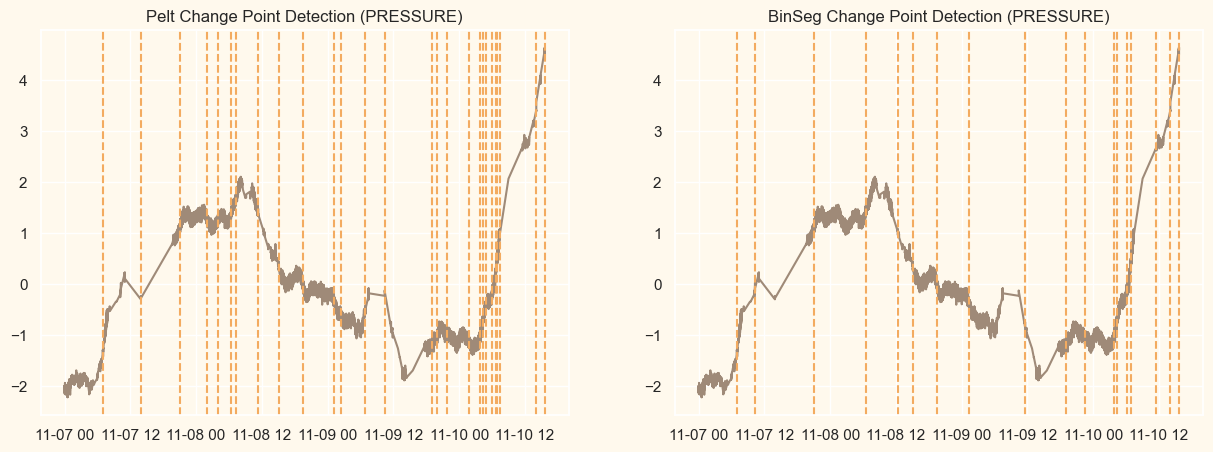

In [169]:
DrawGraphs(df_standardized, 'pressure', pressure_bkps, pressure_bkps2)

In [170]:
magnitudes_pelt_pressure = calculate_magnitude(df_standardized['pressure'], pressure_bkps)
magnitudes_binseg_pressure = calculate_magnitude(df_standardized['pressure'], pressure_bkps2)

print(magnitudes_pelt_pressure)
print(magnitudes_binseg_pressure)

[1.0133809103056737, 0.3498990032534508, 0.03395162445672506, 0.043724884087483096, 0.15545463325419062, 0.18646548281091335, 0.3305740384446938, 0.6310745977123683, 0.3185248375815217, 0.24122731557140448, 0.20648612818847673, 0.15681526577808164, 0.13654976091554058, 0.475030879460587, 0.10377185935433086, 0.02064097142820709, 0.07664677147725474, 0.10094715773270813, 0.28351214518896906, 0.12809492514284387, 0.1437159398351921, 0.3221069002876906, 0.29557414923387443, 0.35285030569047504, 1.500741189110033, 0.5076574965383891]
[1.1915346016717483, 0.9988375459147601, 0.2935938687372952, 0.46686633610639006, 0.7397961699628285, 0.3055485476477797, 0.35255768093694223, 0.27863343110198485, 0.2940809894615174, 0.1899144771103185, 0.056397143597874844, 0.2833396959468425, 0.512810679793272, 0.4774041421756131, 2.203384799442231, 0.7646728738329451, 1.1623559778332284]


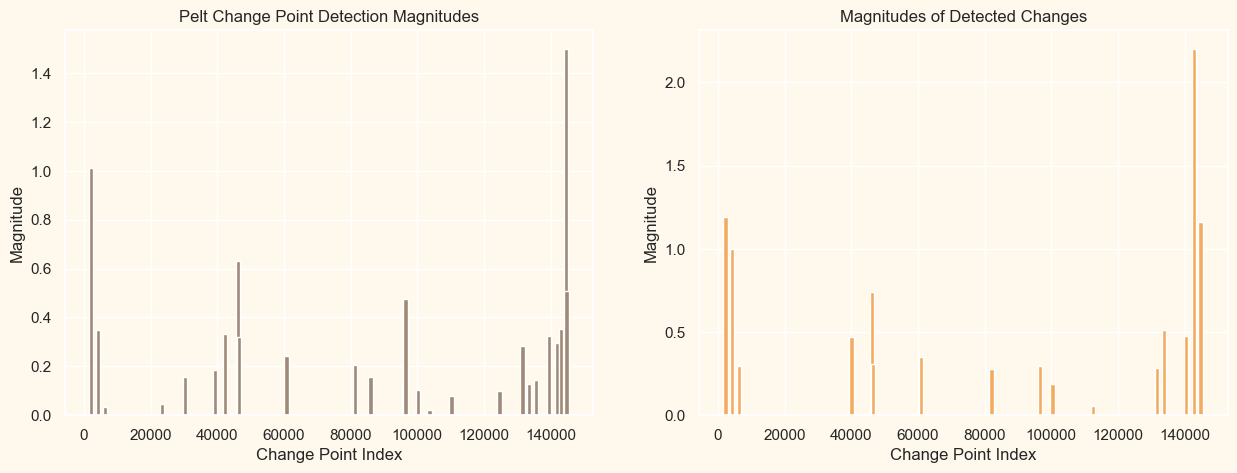

In [171]:
plot_magnitudes(pressure_bkps, pressure_bkps2, magnitudes_pelt_pressure, magnitudes_binseg_pressure)

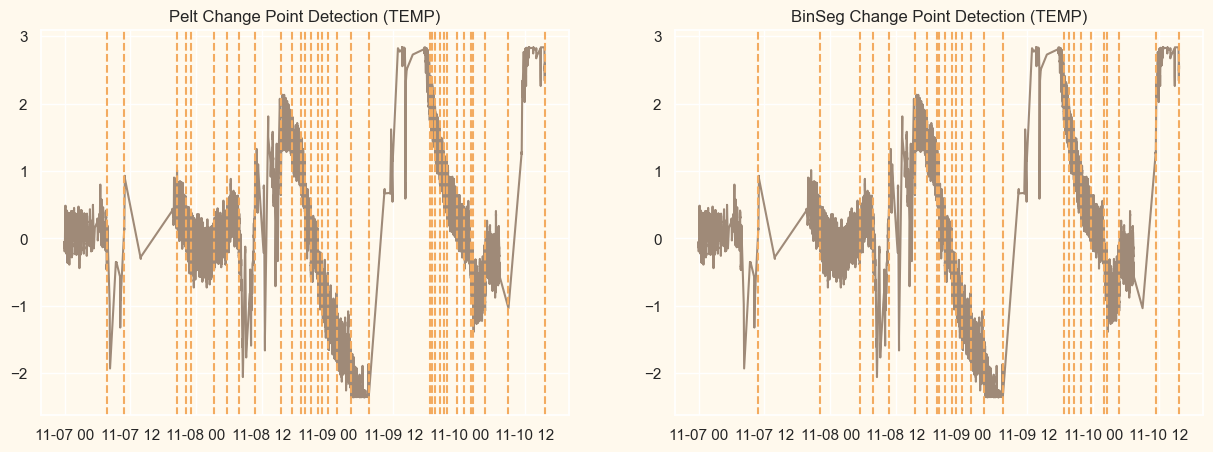

In [172]:
DrawGraphs(df_standardized, 'temp', temp_bkps, temp_bkps2)

In [173]:
magnitudes_pelt_temp = calculate_magnitude(df_standardized['pressure'], temp_bkps)
magnitudes_binseg_temp = calculate_magnitude(df_standardized['pressure'], temp_bkps2)

print(magnitudes_pelt_temp)
print(magnitudes_binseg_temp)

[0.8897213676884549, 0.8329041086143534, 0.38869735132627103, 0.046908815666447445, 0.0894308871056313, 0.015773623724790964, 0.6956176475073417, 0.23682652596809417, 1.4045194134499002, 0.12412331537104965, 0.1297855983853698, 0.36822172413707444, 0.11347889362719578, 0.06597931187701948, 0.06372671651713915, 0.12864739083590615, 0.30351288071268817, 0.23386786611683474, 0.5017814237880428, 1.0392234677736794, 0.1445172723501582, 0.025236226292626673, 0.14588985373475727, 0.02065063380083909, 0.07671167392368061, 0.19151540840213754, 0.2356576639083633, 0.21322122304910962, 0.11618612564451736, 0.6561890050398449, 2.556956870949489, 1.9308400129453123]
[1.1037139680410375, 0.15161762990165806, 0.6917808318402057, 0.2950062552007846, 1.3402621871893068, 0.06752037094922203, 0.2279313416420598, 0.0885339595262617, 0.10552666698032383, 0.05052273285406203, 0.0042130866278055484, 0.11507659416104024, 0.28801197145539736, 0.2259402126326177, 0.5092319487177197, 1.0311301644170705, 0.225515

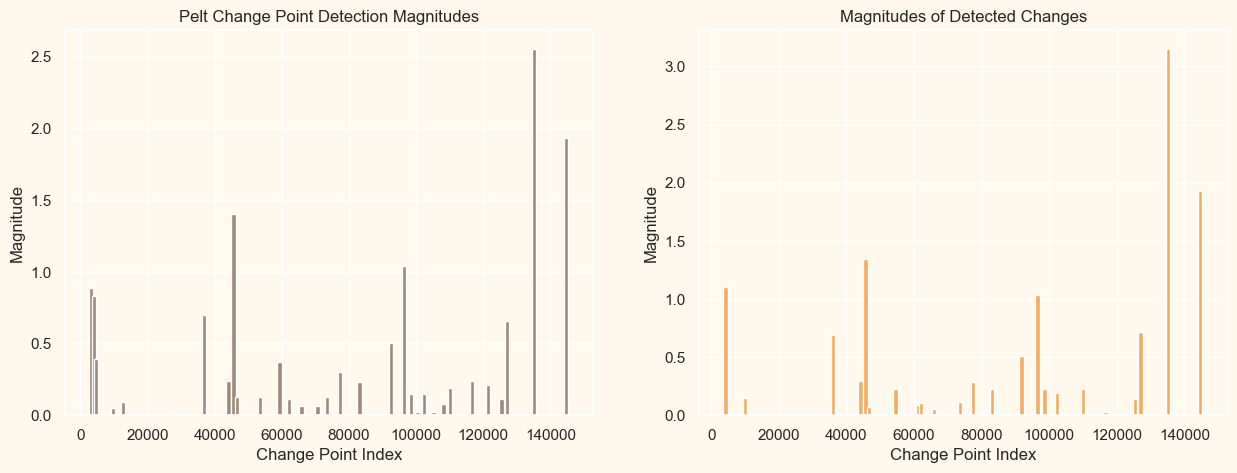

In [174]:
plot_magnitudes(temp_bkps, temp_bkps2, magnitudes_pelt_temp, magnitudes_binseg_temp)

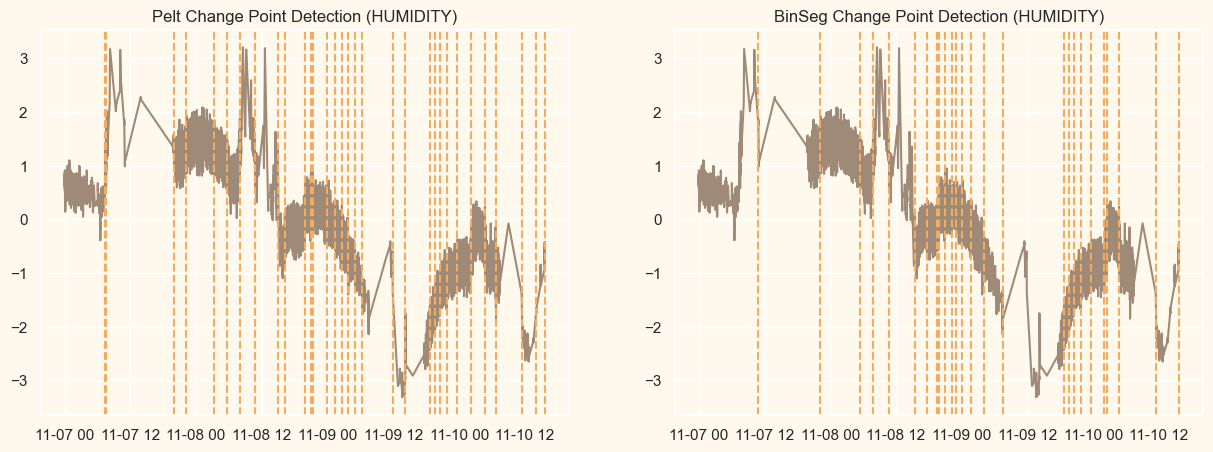

In [175]:
DrawGraphs(df_standardized, 'humidity', humidity_bkps, humidity_bkps2)

In [176]:
magnitudes_pelt_humidity = calculate_magnitude(df_standardized['humidity'], humidity_bkps)
magnitudes_binseg_humidity = calculate_magnitude(df_standardized['pressure'], humidity_bkps2)

print(magnitudes_pelt_humidity)
print(magnitudes_binseg_humidity)

[0.4810481398993174, 0.15755288566675563, 0.020190237976272618, 0.17995358475366885, 0.29581064714424277, 0.09782763916528125, 0.13494181143161832, 0.0366275255165015, 0.33265508543782524, 0.3520668977669448, 0.3258352665007556, 0.007624173630306541, 0.22715934094084597, 0.10820713264266119, 0.010813068021574779, 0.22111252884481308, 0.26241080738804523, 0.3647140020953966, 0.10870782439864235, 0.28325410749388213, 0.5872272013559918, 0.3022144055414744, 0.28776223533153056, 0.22870425945619188, 0.1852764263238703, 0.1748876237256657, 0.003134841003912925, 0.38427125695966136, 0.3375400447814567, 0.507959766880089, 0.6663654875795806]
[1.1037139680410375, 0.15161762990165806, 0.6917808318402057, 0.2950062552007846, 1.3402621871893068, 0.06752037094922203, 0.2279313416420598, 0.0885339595262617, 0.10552666698032383, 0.05052273285406203, 0.0042130866278055484, 0.11507659416104024, 0.28801197145539736, 0.2259402126326177, 0.5092319487177197, 1.0311301644170705, 0.22551569774598867, 0.1872

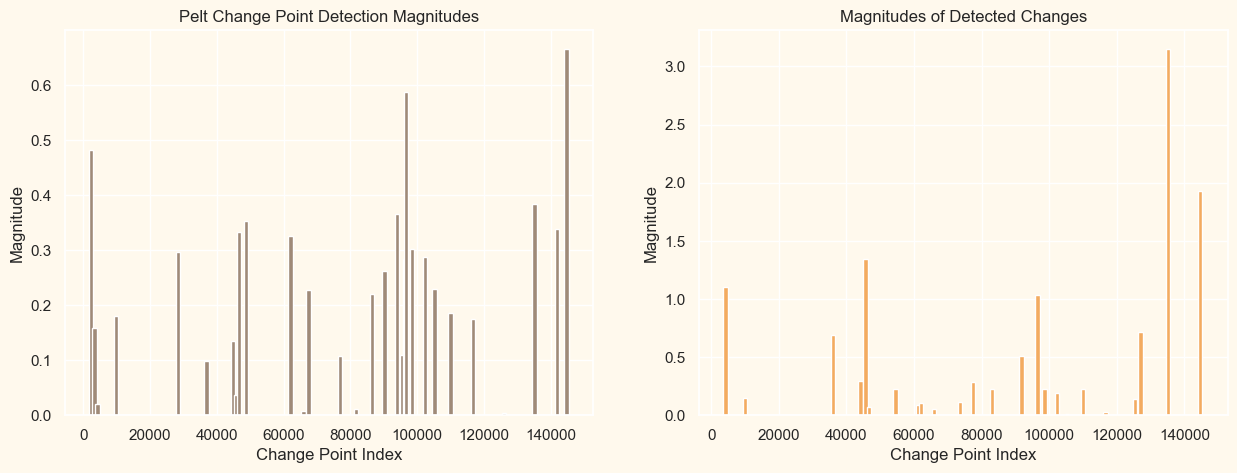

In [177]:
plot_magnitudes(humidity_bkps, humidity_bkps2, magnitudes_pelt_humidity, magnitudes_binseg_humidity)

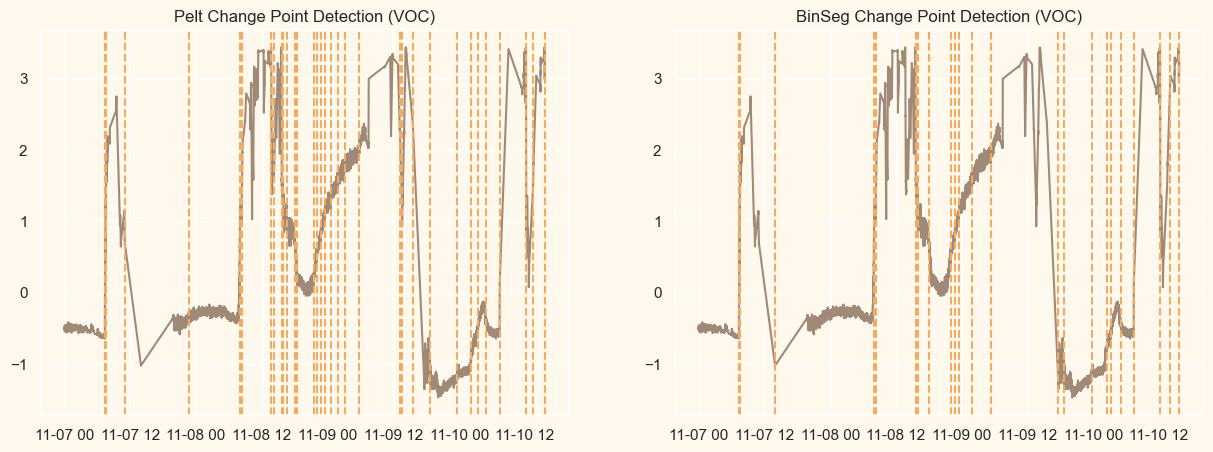

In [178]:
DrawGraphs(df_standardized, 'voc', voc_bkps, voc_bkps2)

In [179]:
magnitudes_pelt_voc = calculate_magnitude(df_standardized['voc'], voc_bkps)
magnitudes_binseg_voc = calculate_magnitude(df_standardized['voc'], voc_bkps2)

print(magnitudes_pelt_voc)
print(magnitudes_binseg_voc)

[0.7819851143545978, 0.7395994325867523, 0.7518851374469975, 1.0467420540928787, 0.6535994985650371, 1.31702756101827, 0.40358540465905035, 0.11487134044329128, 0.10811420277015626, 1.0123420804841927, 0.28932834945877095, 0.2659855102243055, 0.35997115240518013, 0.07862851110556834, 0.25185694963502364, 0.3046854805340774, 0.262299798766232, 0.23957124477477865, 0.19165699581982287, 0.17445700901547978, 0.24264267098983971, 0.2696712216823789, 0.01965712777639217, 0.1713855828004185, 0.11794276665835257, 0.06388566527327444, 0.28502835275768545, 0.3771711392095233, 0.06388566527327433, 0.5516281482250031, 0.9681135429873104, 0.9386278513227223, 0.26045694303719547]
[0.6879994721737231, 0.8513993468149824, 2.4215124279543003, 1.4134703441711938, 1.2347133384546283, 0.09152850120882583, 0.8059422388320756, 0.5424138695798192, 0.14374274686486715, 0.3458425918158984, 0.303456910048053, 0.43245681108062617, 0.3845425621256704, 3.2471117945627688, 0.16831415658535742, 0.029485691664588032,

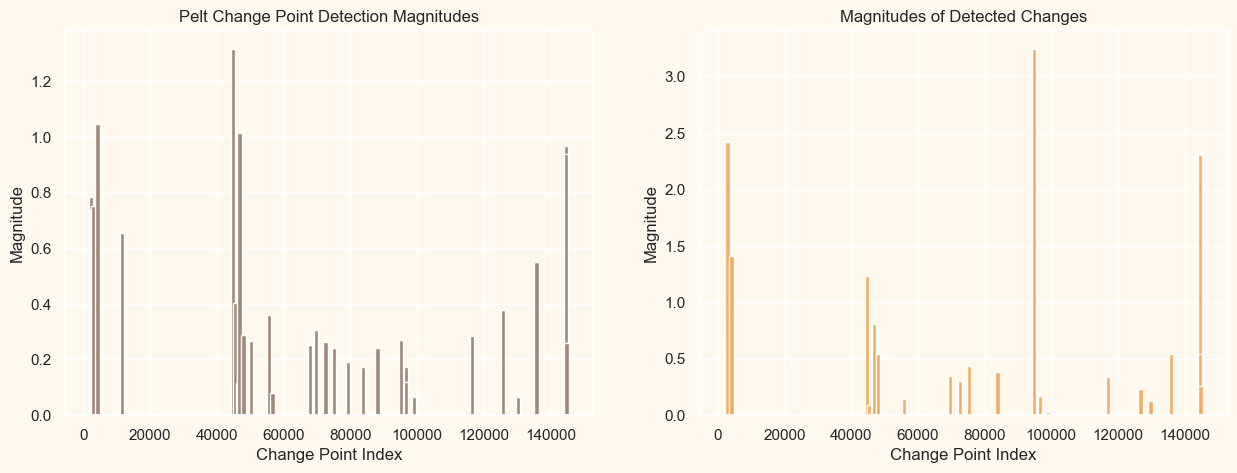

In [180]:
plot_magnitudes(voc_bkps, voc_bkps2, magnitudes_pelt_voc, magnitudes_binseg_voc)

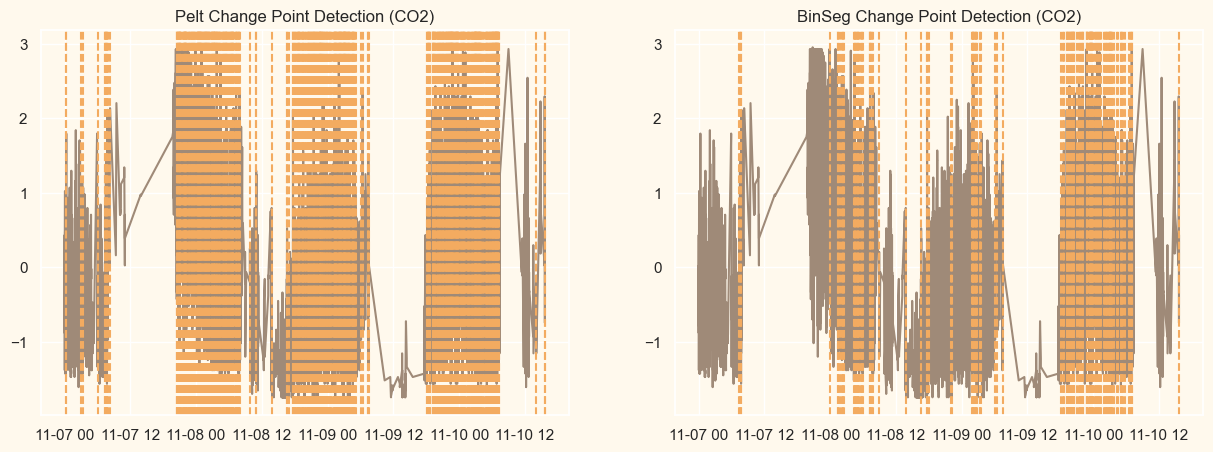

In [181]:
DrawGraphs(df_standardized, 'CO2', CO2_bkps, CO2_bkps2)

In [182]:
magnitudes_pelt_CO2 = calculate_magnitude(df_standardized['CO2'], CO2_bkps)
magnitudes_binseg_CO2 = calculate_magnitude(df_standardized['CO2'], CO2_bkps2)

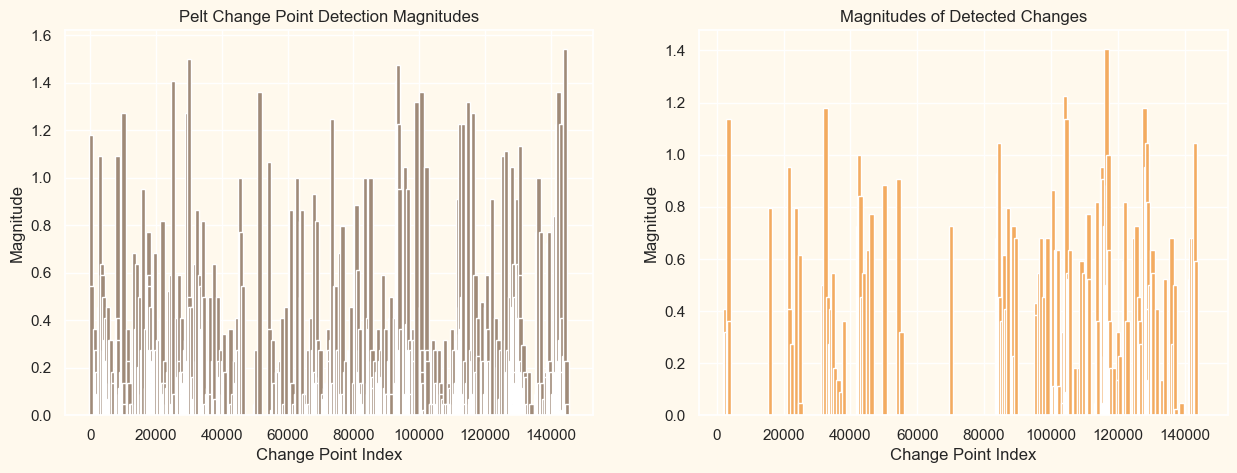

In [183]:
plot_magnitudes(CO2_bkps, CO2_bkps2, magnitudes_pelt_CO2, magnitudes_binseg_CO2)

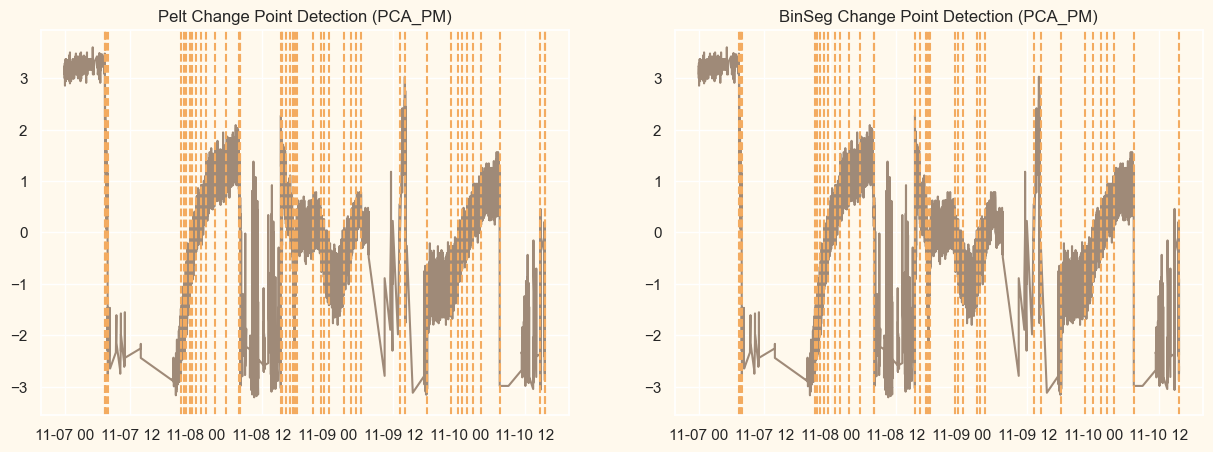

In [184]:
DrawGraphs(df_standardized, 'PCA_pm', PCA_pm_bkps, PCA_pm_bkps2)

In [185]:
magnitudes_pelt_PCA_pm = calculate_magnitude(df_standardized['PCA_pm'], PCA_pm_bkps)
magnitudes_binseg_PCA_pm = calculate_magnitude(df_standardized['PCA_pm'], PCA_pm_bkps2)

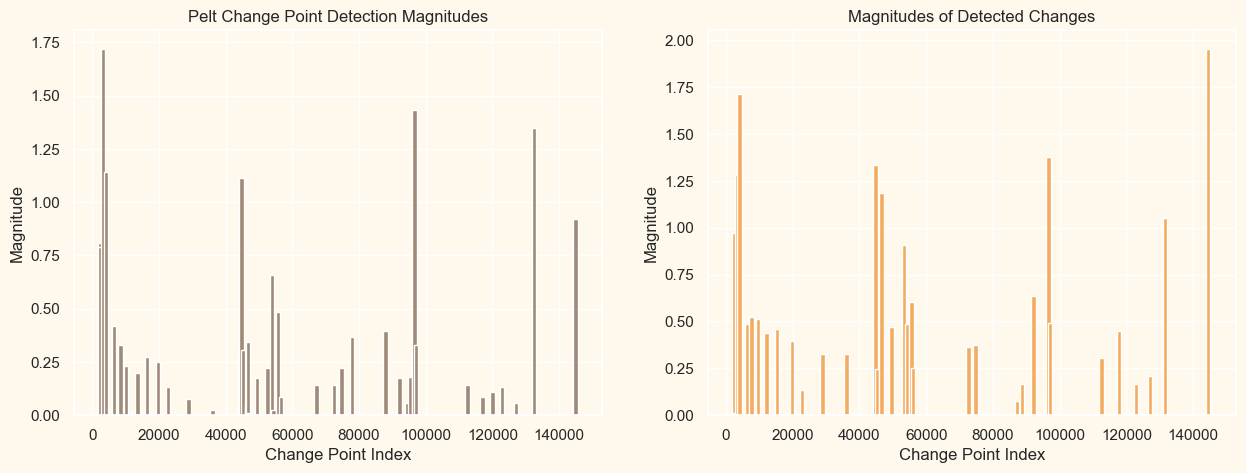

In [186]:
plot_magnitudes(PCA_pm_bkps, PCA_pm_bkps2, magnitudes_pelt_PCA_pm, magnitudes_binseg_PCA_pm)


# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Change point detection - Multivariate (PELT)</p>

In [187]:
data = np.array(df_standardized)

Koristimo elbow krivu kako bismo odredili optimalnu vrednost za penalty.

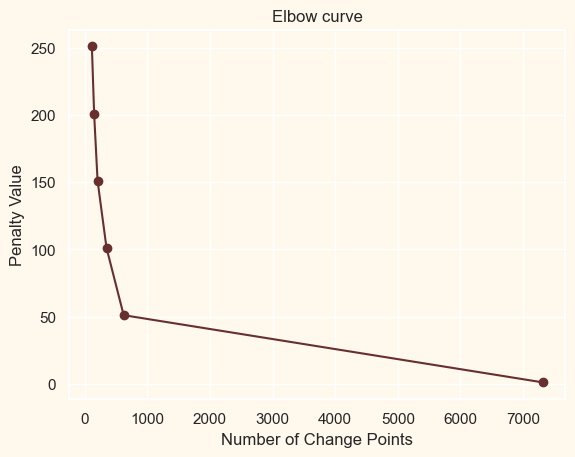

In [188]:
penalty_values = np.arange(1, 300, 50)  # Adjust range as needed
num_change_points = []
# Calculate the number of change points for each penalty value
for penalty in penalty_values:
    algo_c = rpt.KernelCPD(kernel="linear", min_size=5, jump=10).fit(signal)
    result = algo_c.predict(pen=penalty)
    num_change_points.append(len(result))

# Plotting
plt.plot(num_change_points, penalty_values, marker='o')
plt.xlabel("Number of Change Points")
plt.ylabel("Penalty Value")
plt.title("Elbow curve")
plt.grid(True)
plt.show()

Primećujemo da je optimalno rešenje otprilike na vrednosti 52 za penalty_value.

In [189]:
signal = data
algo_c = rpt.KernelCPD(kernel="linear", min_size=5, jump=10).fit(signal)  # written in C, same class as before
bkps_pelt = algo_c.predict(pen=52)

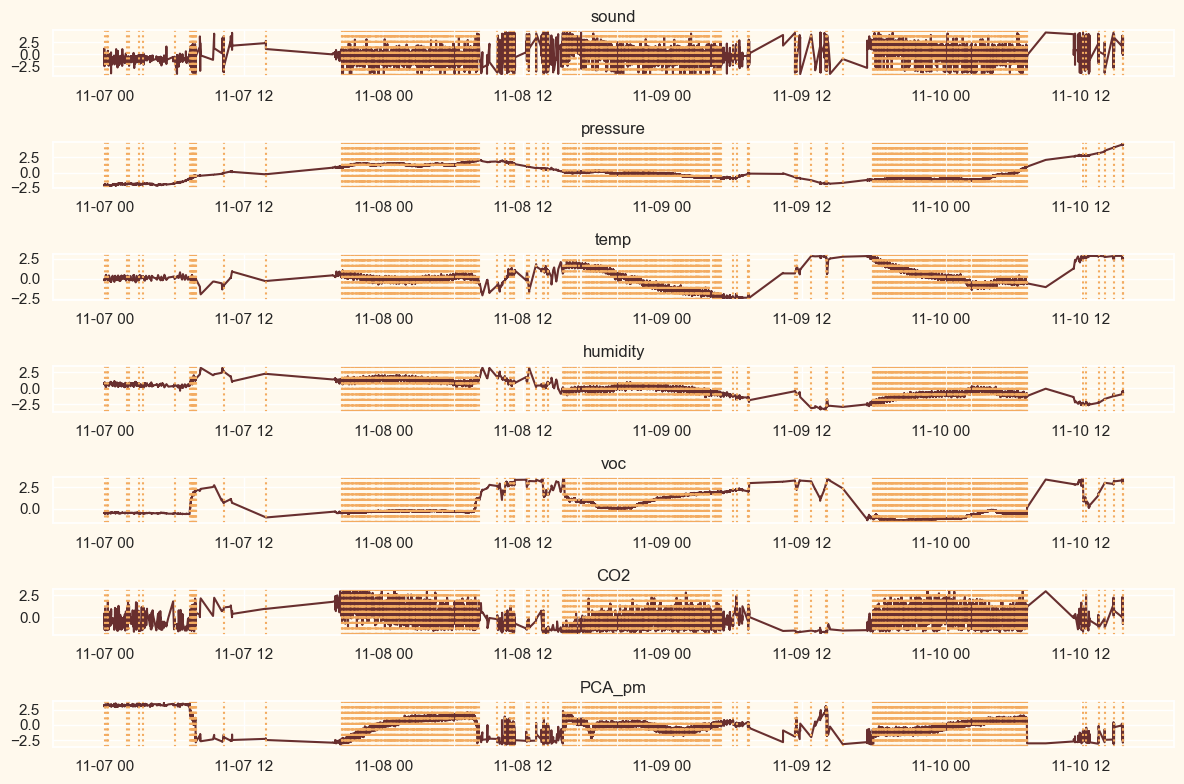

In [190]:
# Get the number of features in the dataset
num_features = df_standardized.shape[1]

# Set the number of columns for the subplots (e.g., 2, 3, 4, etc.)
num_cols = 1

# Calculate the number of rows needed for the subplots
num_rows = (num_features + num_cols - 1) // num_cols

# Create the main figure and subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 8))

# Flatten the 2D subplots array into a 1D array (in case we have only one row or one column of subplots)
axs = axs.ravel()

# Loop through each feature and create a plot for it
for i, feature in enumerate(df_standardized.columns):
    axs[i].plot(df_standardized[feature])
    axs[i].set_title(feature)
    for r in bkps_pelt:
        axs[i].axvline(x=df_standardized.index[r-1], color="#F3AB60", linestyle=':')

# Adjust the layout to prevent overlapping of subplots
plt.tight_layout()
# Show the plot
plt.show()


In [191]:
distances_pelt = calculate_magnitudes_multivariate(df_standardized, bkps_pelt)
distances_pelt.append(0)
distances_pelt.append(0)

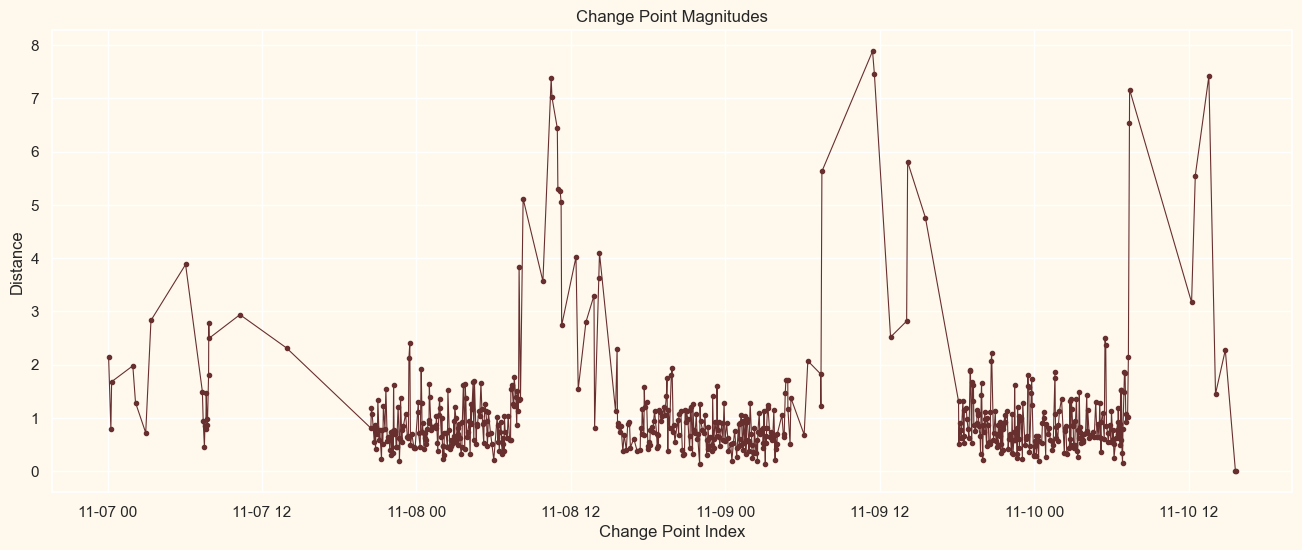

In [192]:
indices = [df_standardized.index[bkp - 1] for bkp in bkps_pelt]

plt.figure(figsize=(16, 6))
plt.plot(indices, distances_pelt, marker='o', linestyle='-', linewidth=0.8, markersize=3)
plt.xlabel('Change Point Index')
plt.ylabel('Distance')
plt.title('Change Point Magnitudes')
plt.grid(True)
plt.show()

Analizom grafikona, moguće je zaključiti da je PELT algoritam pokazao zadovoljavajuće performanse u ovoj situaciji. Ovaj zaključak proizlazi iz evaluacije euklidskog rastojanja među vrednostima vremenskih serija u trenutku detekcije tačke promene i neposredno nakon nje. Veća vrednost euklidskog rastojanja ukazuje na značajniju promenu u tom trenutku. Imajući u vidu učestale skokove i padove na grafikonu, može se zaključiti da se ovaj algoritam pokazao adekvatnim za konkretnu situaciju.

# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Change point detection - Multivariate (BinSeg)</p>

In [195]:
signal = data
algo = rpt.Binseg(model="l2", min_size=10, jump=5,).fit(signal)  # written in C, same class as before
bkps_binseg = algo.predict(pen=52)

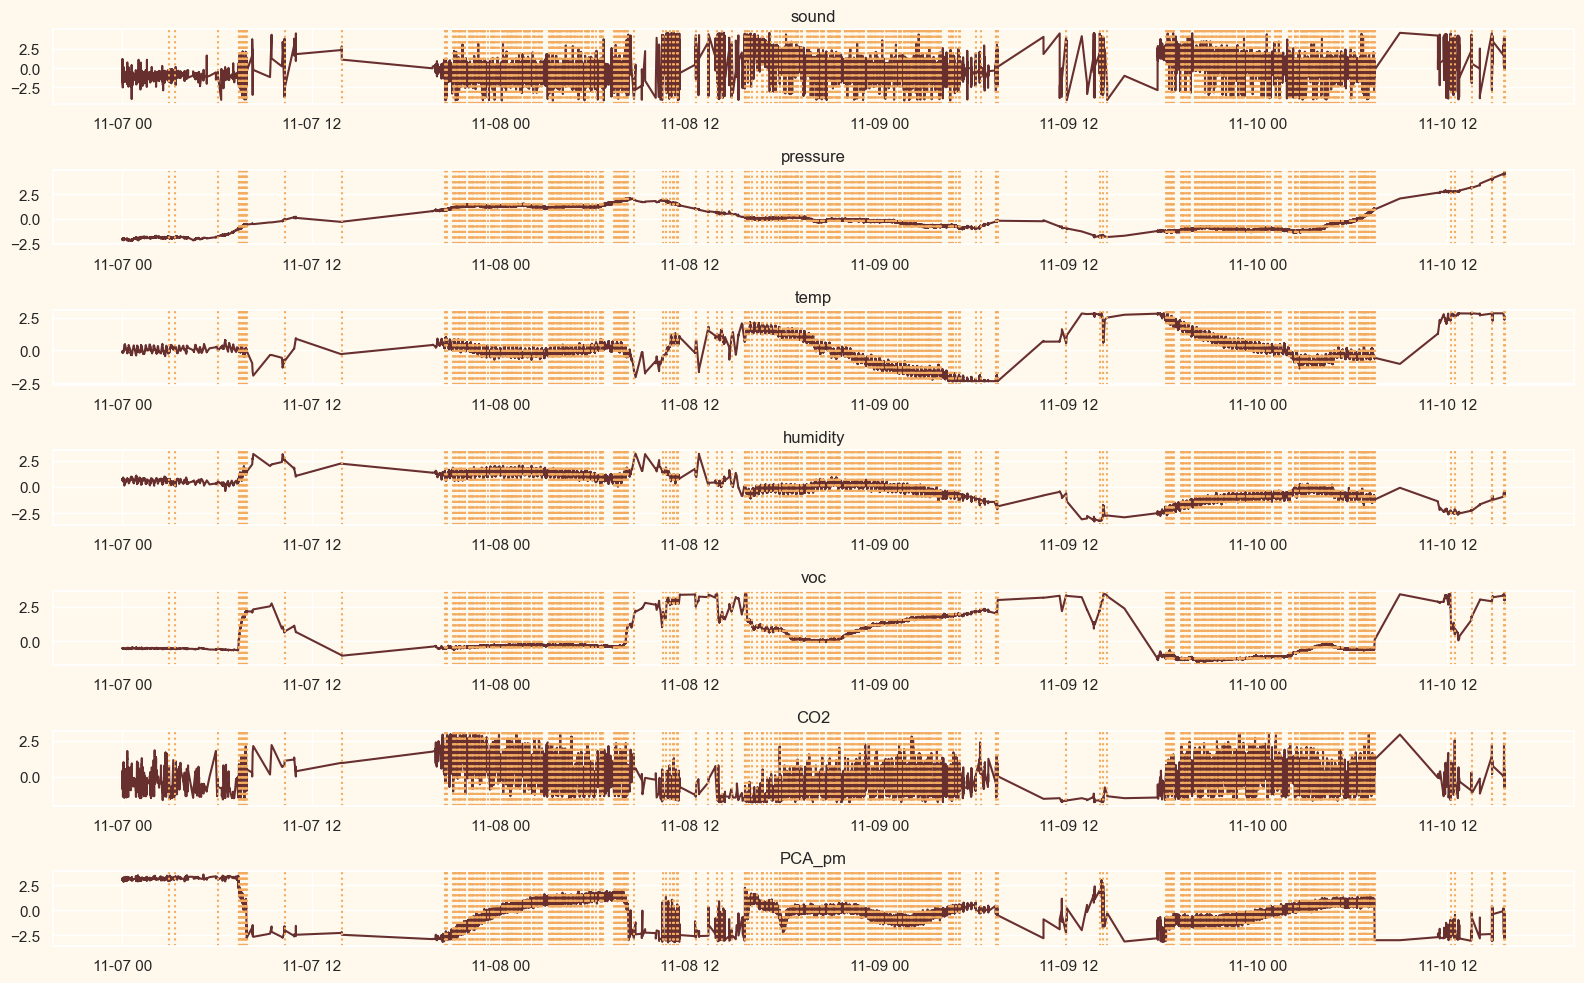

In [196]:
# Get the number of features in the dataset
num_features = df_standardized.shape[1]

# Set the number of columns for the subplots (e.g., 2, 3, 4, etc.)
num_cols = 1

# Calculate the number of rows needed for the subplots
num_rows = (num_features + num_cols - 1) // num_cols

# Create the main figure and subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(16, 10))

# Flatten the 2D subplots array into a 1D array (in case we have only one row or one column of subplots)
axs = axs.ravel()

# Loop through each feature and create a plot for it
for i, feature in enumerate(df_standardized.columns):
    axs[i].plot(df_standardized[feature])
    axs[i].set_title(feature)
    for r in bkps_binseg:
        axs[i].axvline(x=df_standardized.index[r-1], color="#F3AB60", linestyle=':')

# Adjust the layout to prevent overlapping of subplots
plt.tight_layout()
# Show the plot
plt.show()

In [197]:
distances_binseg = calculate_magnitudes_multivariate(df_standardized, bkps_binseg)
distances_binseg.append(0)
distances_binseg.append(0)

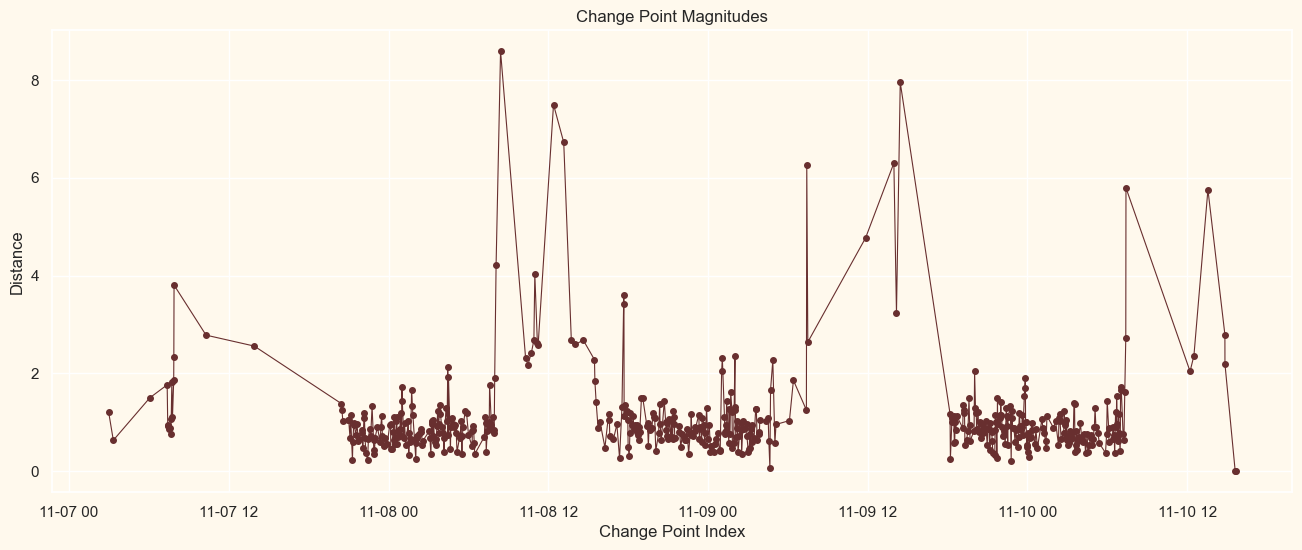

In [198]:
indices = [df_standardized.index[bkp - 1] for bkp in bkps_binseg]

plt.figure(figsize=(16, 6))
plt.plot(indices, distances_binseg, marker='o', linestyle='-', linewidth=0.8, markersize=4)
plt.xlabel('Change Point Index')
plt.ylabel('Distance')
plt.title('Change Point Magnitudes')
plt.grid(True)
plt.show()

Na osnovu temeljne analize dijagrama, moguće je zaključiti da BinSeg algoritam iskazuje zavidne performanse u okviru specifičnog konteksta. Ovaj zaključak proizlazi iz dubinske evaluacije euklidske udaljenosti među vremenskim serijama podataka, obavljene u trenutku detekcije tačke promene i neposredno nakon toga. Uvećane vrednosti euklidske udaljenosti ukazale su na izraženije promene u tim ključnim trenucima. Analizom učestalih skokova i padova na grafikonu, opravdava se zaključak da BinSeg algoritam veoma adekvatno odgovara zahtevima specifične situacije.

Važno je napomenuti da se u ovom konkretnom slučaju pokazalo da algoritam pelt ostvaruje još bolje rezultate, čime se dodatno obogaćuje razmatranje performansi algoritama u datom kontekstu.

# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Change point detection - Multivariate (BottomUp)</p>

In [199]:
signal = data
algo = rpt.BottomUp(model="l2", min_size=10, jump=5,).fit(signal)  # written in C, same class as before
bkps_bottom_up = algo.predict(pen=100)

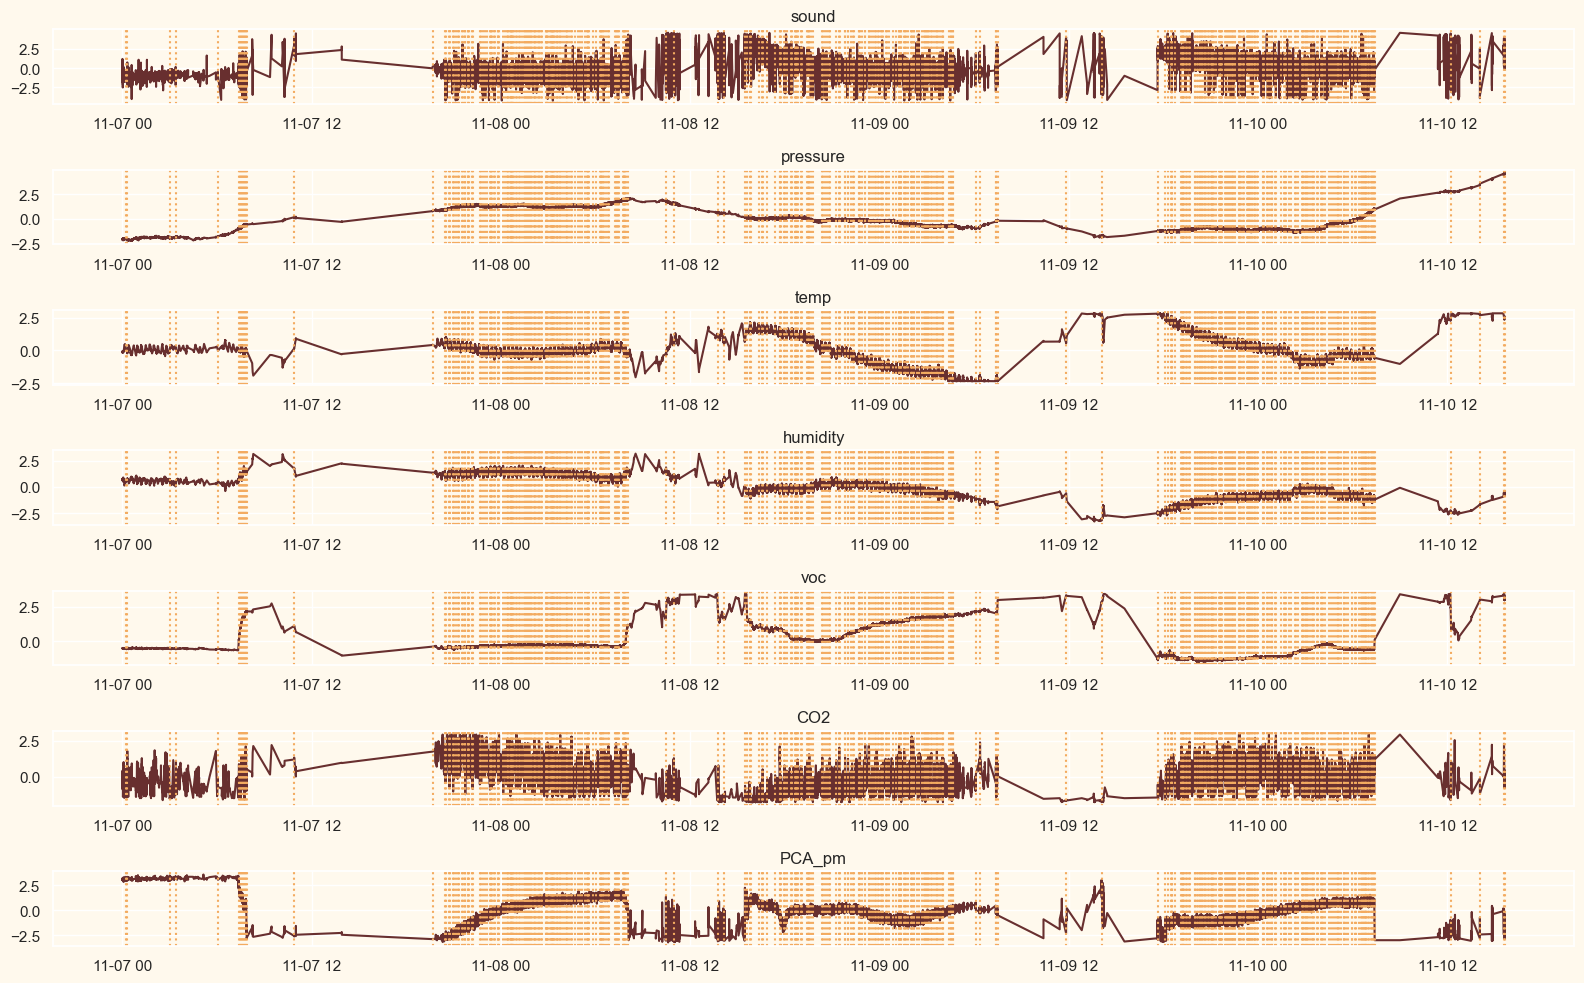

In [200]:
# Get the number of features in the dataset
num_features = df_standardized.shape[1]

# Set the number of columns for the subplots (e.g., 2, 3, 4, etc.)
num_cols = 1

# Calculate the number of rows needed for the subplots
num_rows = (num_features + num_cols - 1) // num_cols

# Create the main figure and subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(16, 10))

# Flatten the 2D subplots array into a 1D array (in case we have only one row or one column of subplots)
axs = axs.ravel()

# Loop through each feature and create a plot for it
for i, feature in enumerate(df_standardized.columns):
    axs[i].plot(df_standardized[feature])
    axs[i].set_title(feature)
    for r in bkps_bottom_up:
        axs[i].axvline(x=df_standardized.index[r-1], color="#F3AB60", linestyle=':')

# Adjust the layout to prevent overlapping of subplots
plt.tight_layout()
# Show the plot
plt.show()

In [201]:
distances_bottom_up = calculate_magnitudes_multivariate(df_standardized, bkps_bottom_up)
distances_bottom_up.append(0)
distances_bottom_up.append(0)

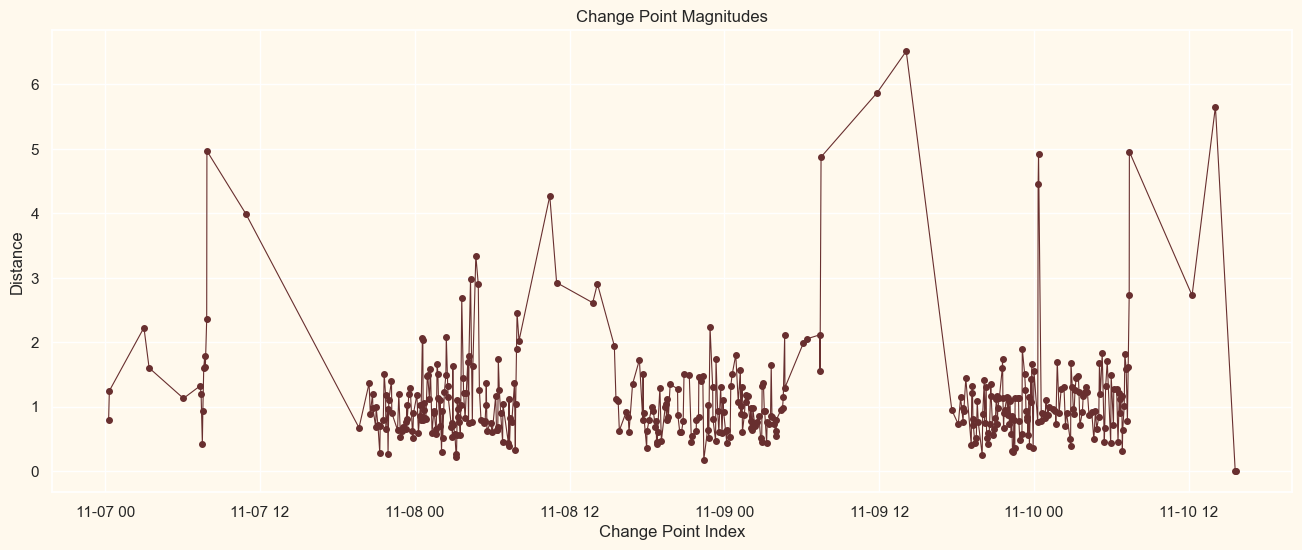

In [202]:
indices = [df_standardized.index[bkp - 1] for bkp in bkps_bottom_up]

plt.figure(figsize=(16, 6))
plt.plot(indices, distances_bottom_up, marker='o', linestyle='-', linewidth=0.8, markersize=4)
plt.xlabel('Change Point Index')
plt.ylabel('Distance')
plt.title('Change Point Magnitudes')
plt.grid(True)
plt.show()

# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">PELT/BinSeg/BottomUp comparison of Euclidean distances</p>

In [203]:
distances_pelt = np.array(distances_pelt)
distances_binseg = np.array(distances_binseg)
distances_bottom_up = np.array(distances_bottom_up)

In [204]:
print(f"PELT distances mean: {distances_pelt.mean()}")
print(f"BinSeg distances mean: {distances_binseg.mean()}")
print(f"BottomUp distances mean: {distances_bottom_up.mean()}")



PELT distances mean: 1.0520368981887571
BinSeg distances mean: 1.0726777755579675
BottomUp distances mean: 1.1363313161430717


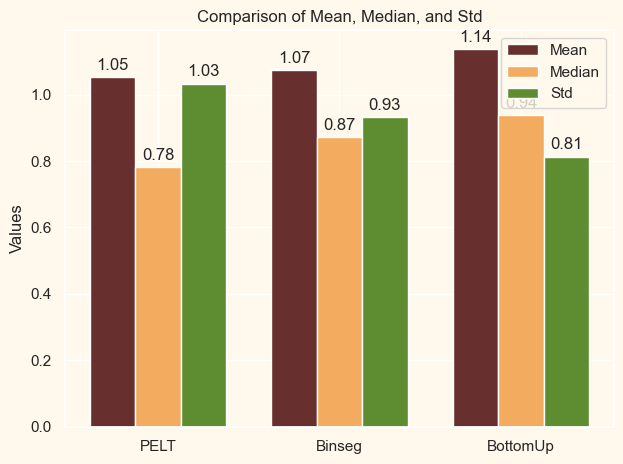

In [205]:
# Calculate mean, median, and standard deviation for both algorithms
mean_pelt = np.mean(distances_pelt)
median_pelt = np.median(distances_pelt)
std_pelt = np.std(distances_pelt)

mean_binseg = np.mean(distances_binseg)
median_binseg = np.median(distances_binseg)
std_binseg = np.std(distances_binseg)

mean_bottom_up = np.mean(distances_bottom_up)
median_bottom_up = np.median(distances_bottom_up)
std_bottom_up = np.std(distances_bottom_up)

# Create a bar plot to visualize the statistics
labels = ['PELT', 'Binseg', 'BottomUp']
mean_values = [mean_pelt, mean_binseg, mean_bottom_up]
median_values = [median_pelt, median_binseg, median_bottom_up]
std_values = [std_pelt, std_binseg, std_bottom_up]

x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, mean_values, width, label='Mean')
rects2 = ax.bar(x, median_values, width, label='Median')
rects3 = ax.bar(x + width, std_values, width, label='Std')

ax.set_ylabel('Values')
ax.set_title('Comparison of Mean, Median, and Std')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.show()


Srednja udaljenost:

Algoritam sa manjom srednjom udaljenošću obično ima tendenciju da u proseku detektuje manje promene. U ovom slučaju, PELT ima nešto manju srednju udaljenost u odnosu na BinSeg i BottomUp. To ukazuje na to da PELT možda najbolje detektuje manje promene uopšteno.

Medijana udaljenosti:

Medijana udaljenosti je manje osetljiva na ekstremne vrednosti u poređenju sa srednjom vrednošću. Niža medijana udaljenosti sugeriše da algoritam dosledno detektuje promene manjeg obima. Sva tri algoritma imaju slične mediane udaljenosti, što ukazuje da svi relativno dosledno detektuju promene. Takođe, najbolje se pokazao PELT algoritam.

Standardna devijacija (Std):

Niža standardna devijacija ukazuje na to da su udaljenosti čvršće grupisane oko srednje vrednosti, što sugeriše veću doslednost u detekciji. U ovom slučaju, sva tri algoritma imaju slične standardne devijacije, što znači da je varijacija u detektovanim obimima promena uporediva.

Shodno svemu navedenom, opredeljujemo se za PELT algoritam.

In [206]:

bkps_pelt_adjusted = [idx - 1 for idx in bkps_pelt]

change_point_labels = [1 if idx in bkps_pelt_adjusted else 0 for idx in range(len(df_standardized))]

result = pd.DataFrame({'timestamp': df_standardized.index, 'change_points': change_point_labels})

result.to_csv('result.csv', index=False)
